# Univariate Volatilty

## Kevin Sheppard

# Today 

* Realized Variance
* Bid-Ask Bounce
* Volatility Signature Plots
* Alternative Estimators
* Modeling and Forecasting $RV$
* Implied Variance

In [1]:
import matplotlib.pyplot as plt
import mfe
import numpy as np
import pandas as pd
import warnings

mfe.outputs["pres"]()
import arch
from arch import arch_model
from arch.univariate.distribution import StudentsT
from arch.univariate.mean import ZeroMean
from arch.univariate.volatility import GARCH
from mfe.slides import figsize, plot, pretty, summary, truncated_plot

warnings.filterwarnings("ignore",message="Values in x were outside",category=RuntimeWarning)

# Realized Variance

* Use UHF data to precisely estimate variance over a given period
  * Typically 1 day
  * Avoids diurnal effects

$$ RV_{t}^{(m)}=\sum_{i=1}^{m}\left(p_{i,t}-p_{i-1,t}\right)^{2}=\sum_{i=1}^{m}r_{i,t}^{2} $$

* Like variance estimator except no need to demean
* Assumption is that $m\rightarrow\infty$
* Estimated _integrated variance_

$$ \lim_{m\rightarrow\infty} RV_{t}^{(m)} = \int_{t}^{t+1}\sigma_{s}^{2}ds $$


# Simulated Brownian Motion

* Assume $\mu$ and $\sigma$ are annualized
$$r_{i,t} \stackrel{iid}{\sim} N\left(\frac{\mu}{252 m},\frac{\sigma^2}{252 m}\right) $$

$$ p_{i,t} = p_{i-1,t} + r_{i,t} $$

* $p_{0,t} = \ln(100)$


In [2]:
import datetime as dt
rg = np.random.default_rng(20210223)
m = 23400
sigma = .2
mu = 0.08
e = mu/(252*m) + rg.standard_normal(23400) * np.sqrt(sigma**2 / (252 *m))
lp = np.log(100) + np.cumsum(np.r_[0,e])
idx = pd.date_range(start=dt.datetime(2021,2,23,9,30,0), end=dt.datetime(2021,2,23,16,0,0), periods=23401)
p = pd.Series(lp, index=idx)

# The price path

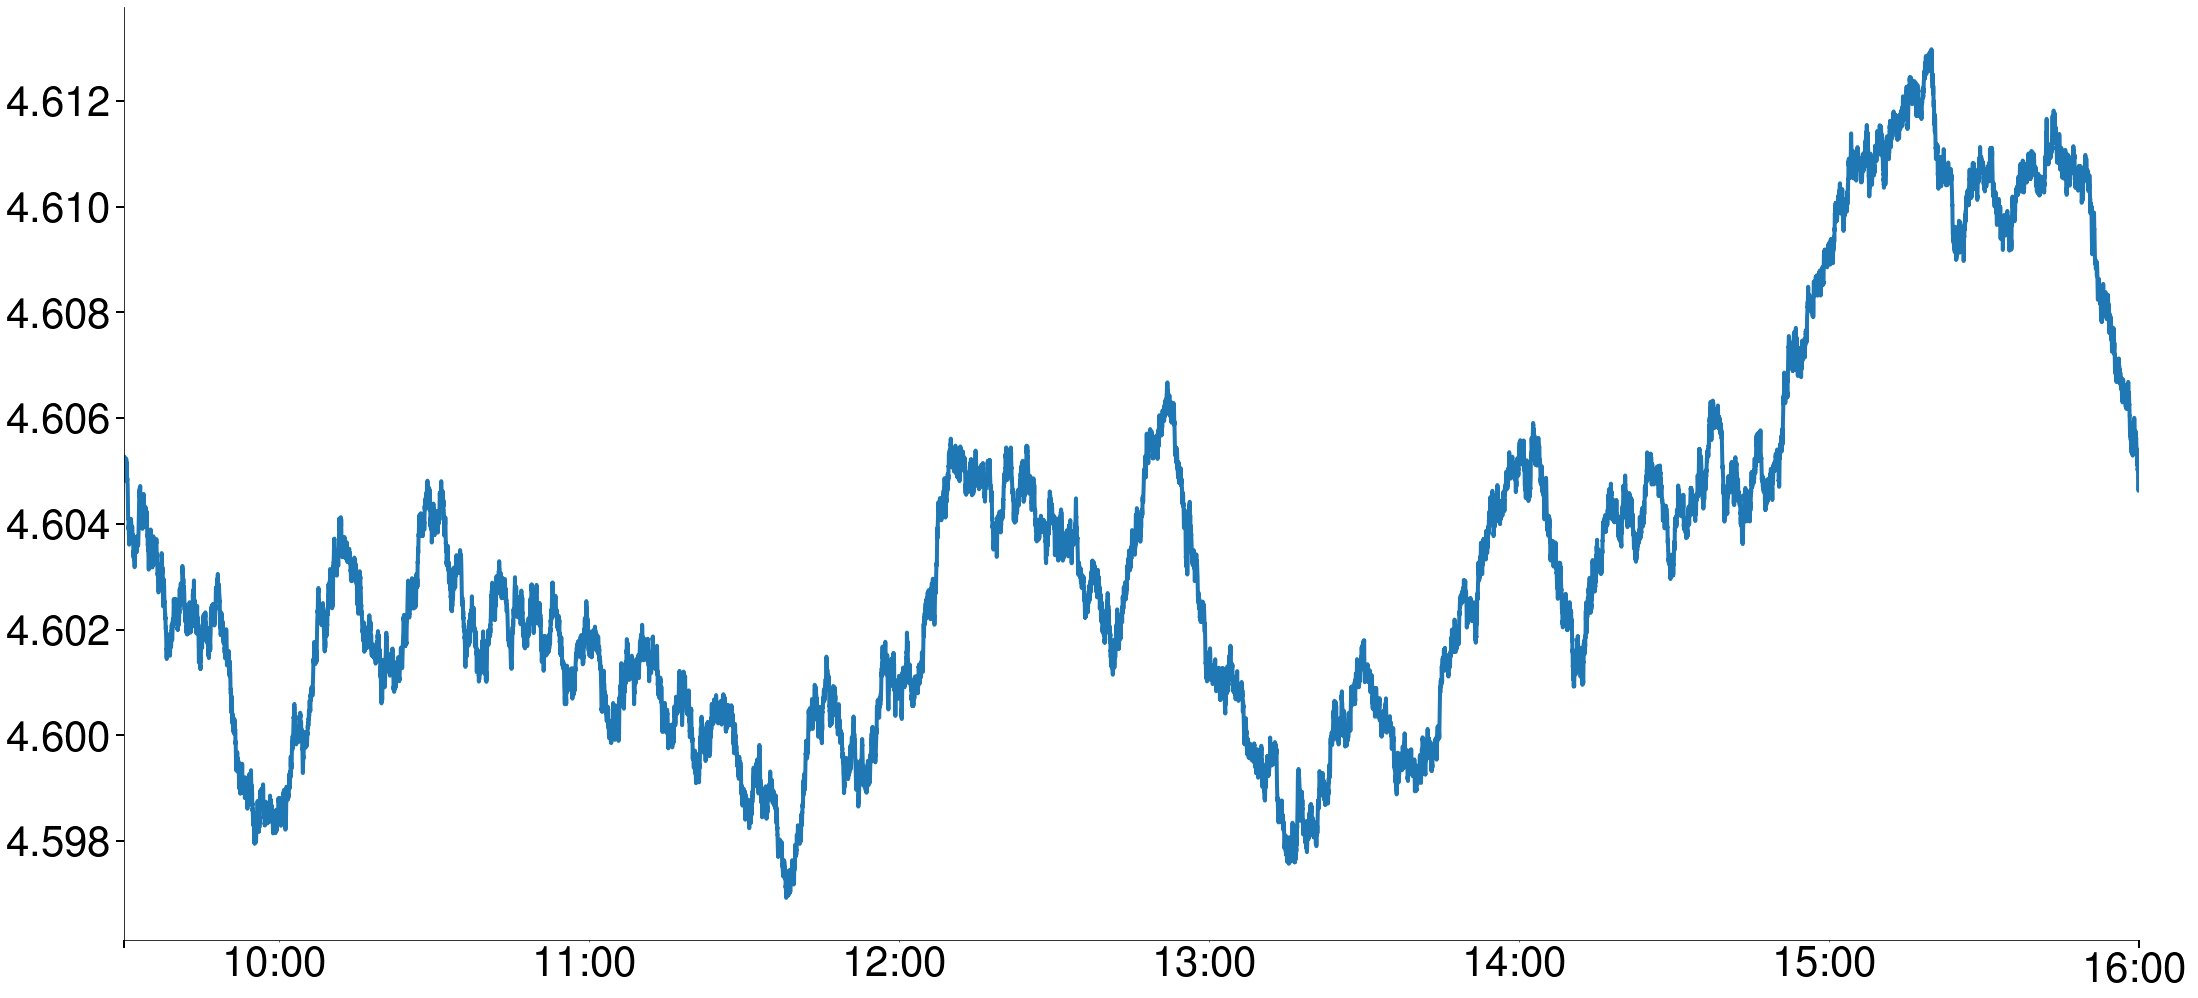

In [3]:
plot(p)

# Implementing $RV$

In [4]:
rv = {}

for i in (13,39,78,390,1560,23400):
    step = m // i
    rets = p.iloc[::step].diff().dropna()
    _rv = (rets**2).sum()
    rv[step] = _rv
np.sqrt(252 * pd.Series(rv))

1800    0.210890
600     0.242003
300     0.209546
60      0.180562
15      0.197455
1       0.200257
dtype: float64

In [5]:
from collections import defaultdict


import datetime as dt
rg = np.random.default_rng(20210223)
m = 23400

def plot_rv():
    rv = defaultdict(list)
    for j in range(100):
        e = mu/(252*m) + rg.standard_normal(23400) * np.sqrt(sigma**2 / (252 *m))
        lp = np.log(100) + np.cumsum(np.r_[0,e])
        p = pd.Series(lp, index=idx)

        for i in (13,39,78,390,1560,23400):
            step = m // i
            _rv = (p.iloc[::step].diff().dropna()**2).sum()
            rv[step].append(_rv)
    rv = pd.DataFrame(rv)
    s0,s1 = mfe.DEFAULT_FIGSIZE
    fig,ax = plt.subplots(1,1,figsize=(s0,s1-1))
    ax = rv.boxplot(ax=ax)
    ax.set_xlabel("Period")
    xl = ax.get_xticklabels()
    _ = ax.set_xticklabels(["30 min","10 min","5 min","1 min","15 sec", "1 sec"])

# $RV$ estimation error

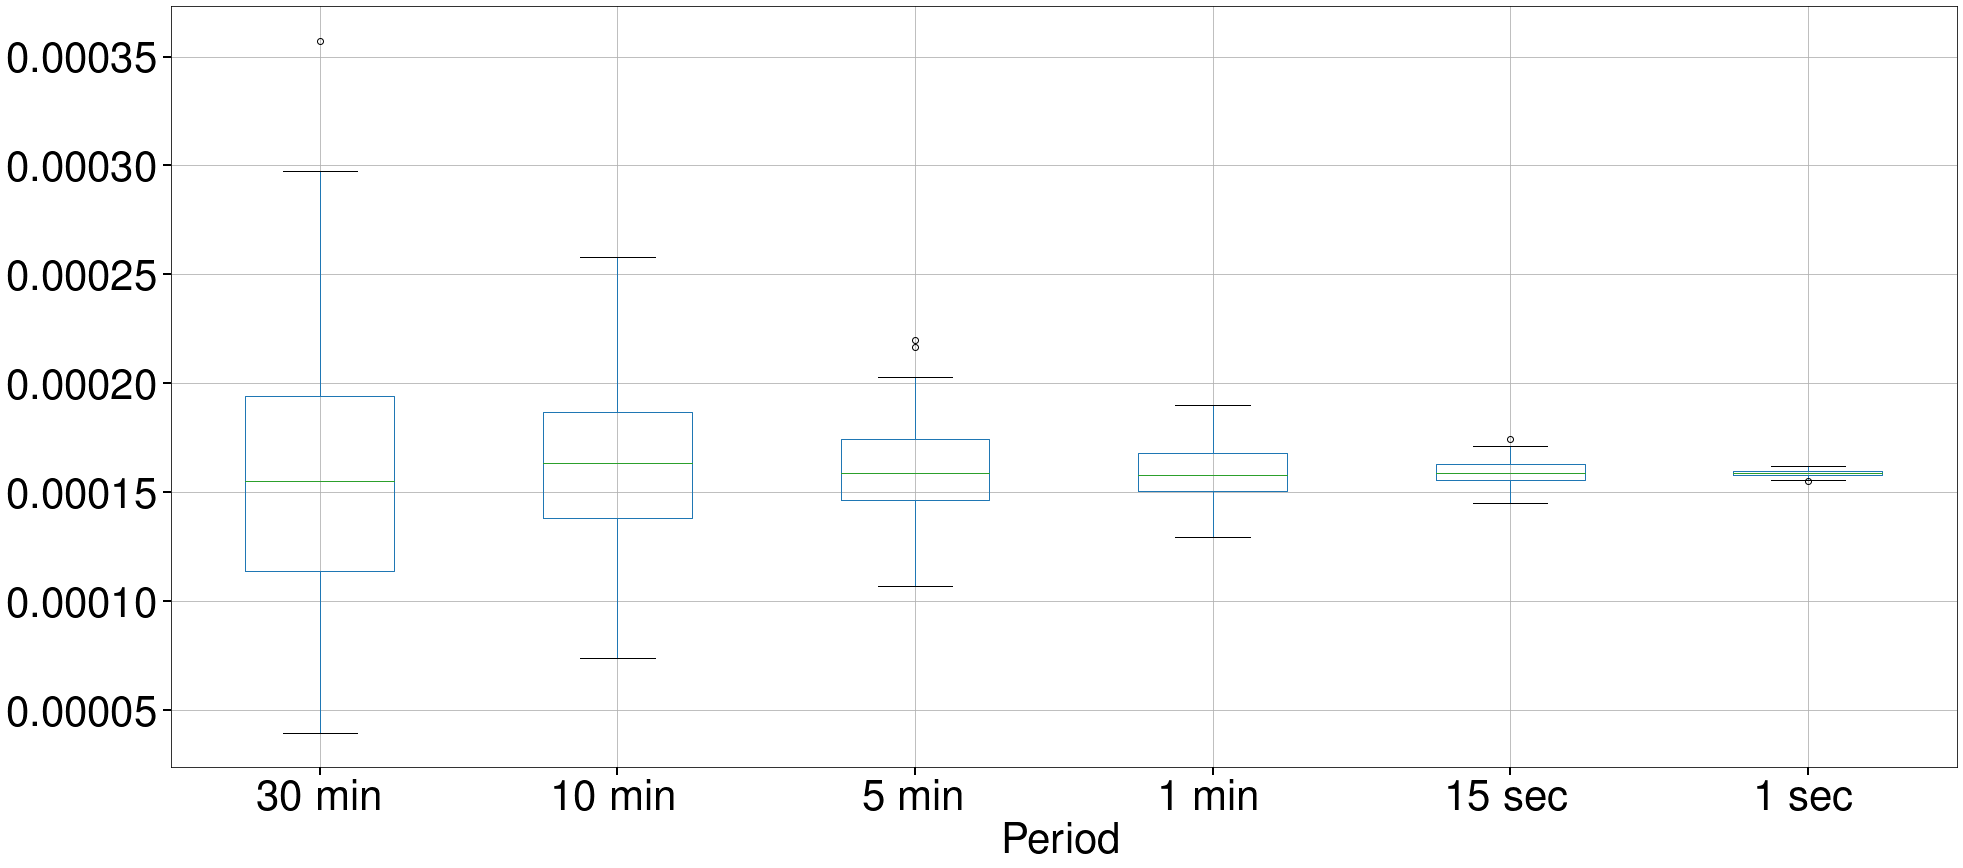

In [6]:
plot_rv()

# Bid-Ask Bounce

* Primary challenge of $RV$ implementation
* Not one price, but two
  * Bid
  * Ask or Offer
* Transactions tend to bound between these two prices
* Creates many high-frequency noise returns
* Observed return is
$$ r_{i,t} = r^\star_{i,t} + \epsilon_{i,t} $$
* $r^\star_{i,t}$ is the return we would like see
* $\epsilon_{i,t}$ follows an MA(1)
$$RV_{t}^{(m)}\approx\widehat{RV}_{t}+m\tau^{2}$$

In [7]:
mq = np.round(np.exp(p),2)
sp = 0.05
locs = np.sort(rg.choice(23401,1000,replace=False))
trans = mq.iloc[locs] + sp * (2*rg.integers(2,size=locs.shape[0],dtype=bool)-1)
def plot_trans(zoom=False):
    tr = trans
    if zoom:
        tr = trans.iloc[:100]
    plot(tr)
    ax = plt.gca()
    ax.lines[0].set_linestyle("none")
    ax.lines[0].set_marker("o")
    if zoom:
        _mq = mq.iloc[locs].iloc[:100]
        ax.plot(tr, color="k", alpha=0.3, zorder=-2)
        ax.plot(_mq+sp,color=mfe.colors[0], zorder=-2)
        ax.plot(_mq-sp,color=mfe.colors[1], zorder=-2)
        ax.lines[0].set_markersize(24)

# Realistic UHF Asset Price

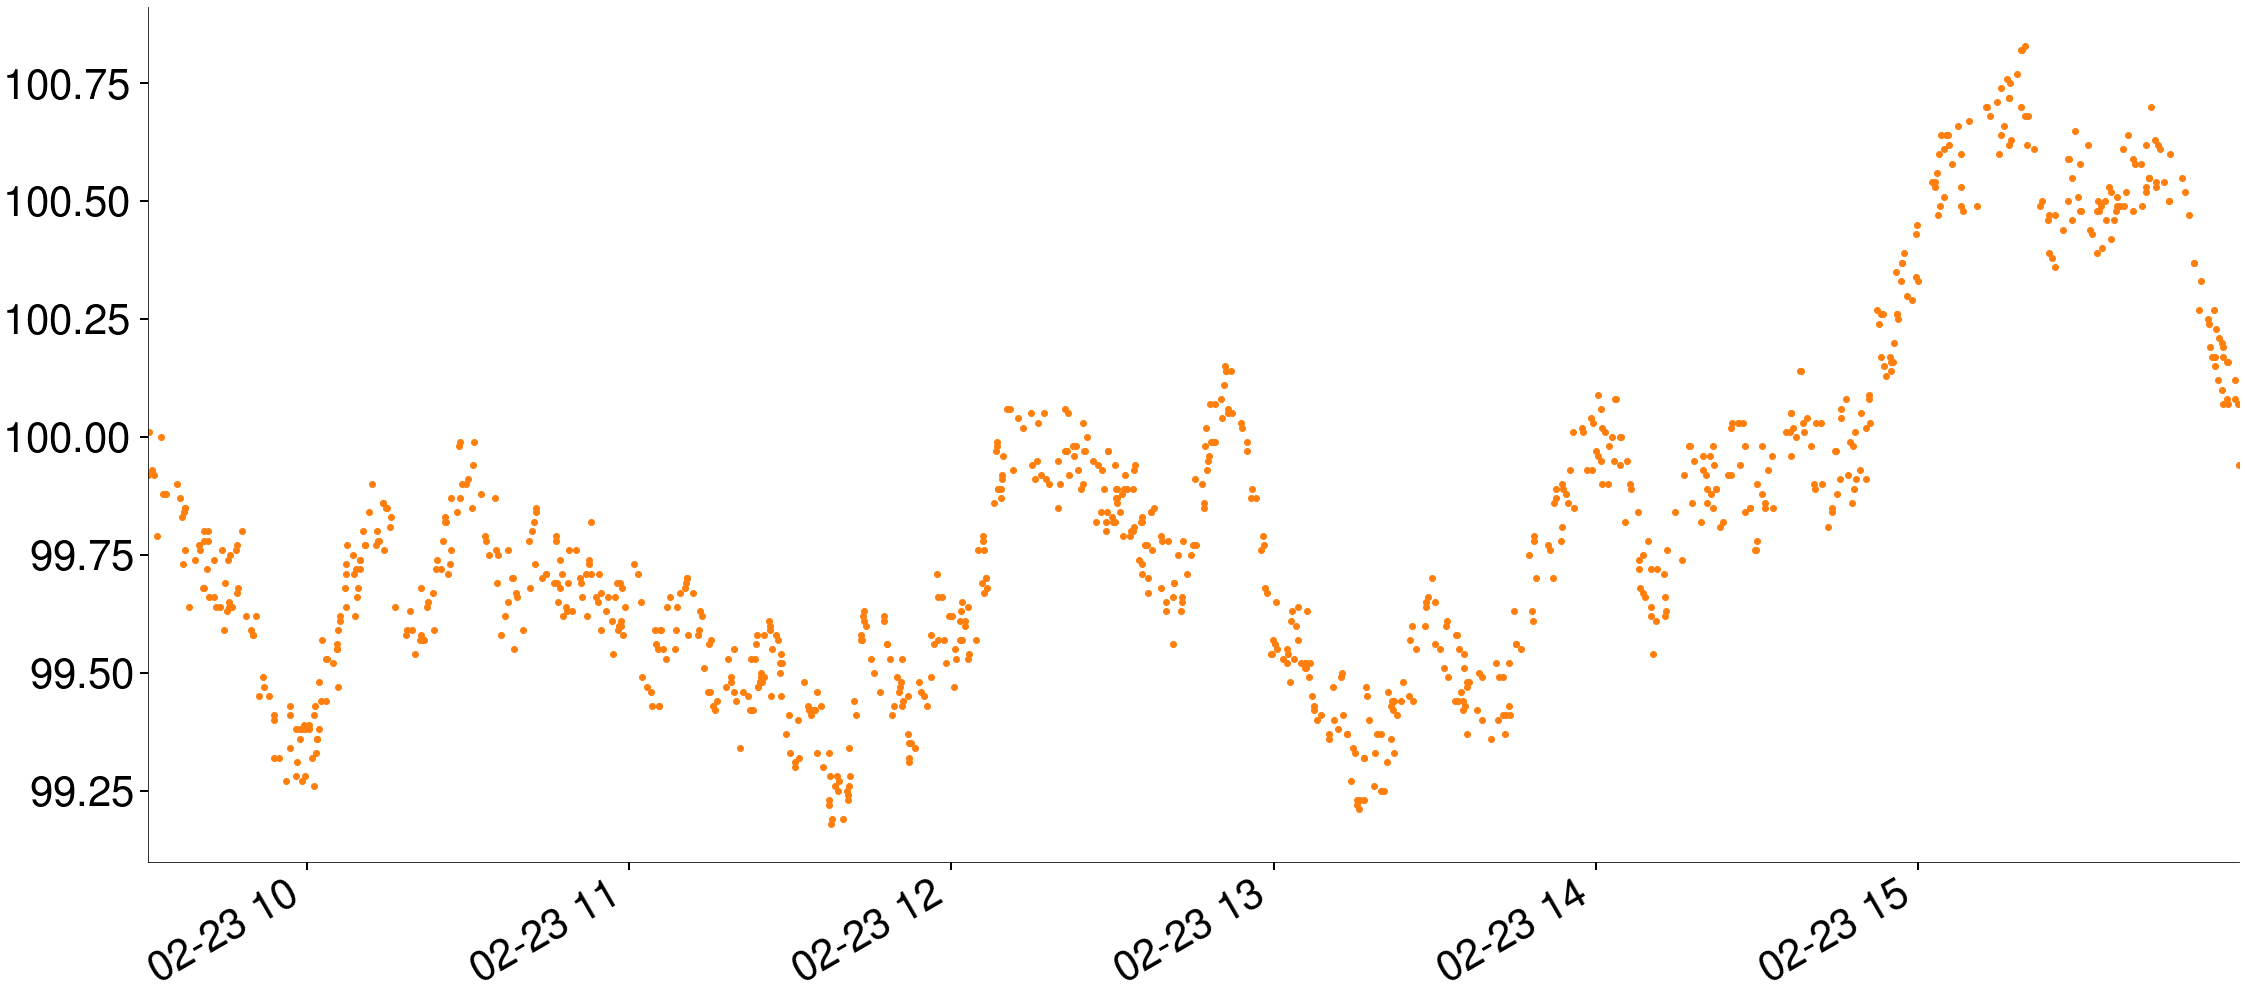

In [8]:
plot_trans()

# Transaction, Bid, and Ask Prices

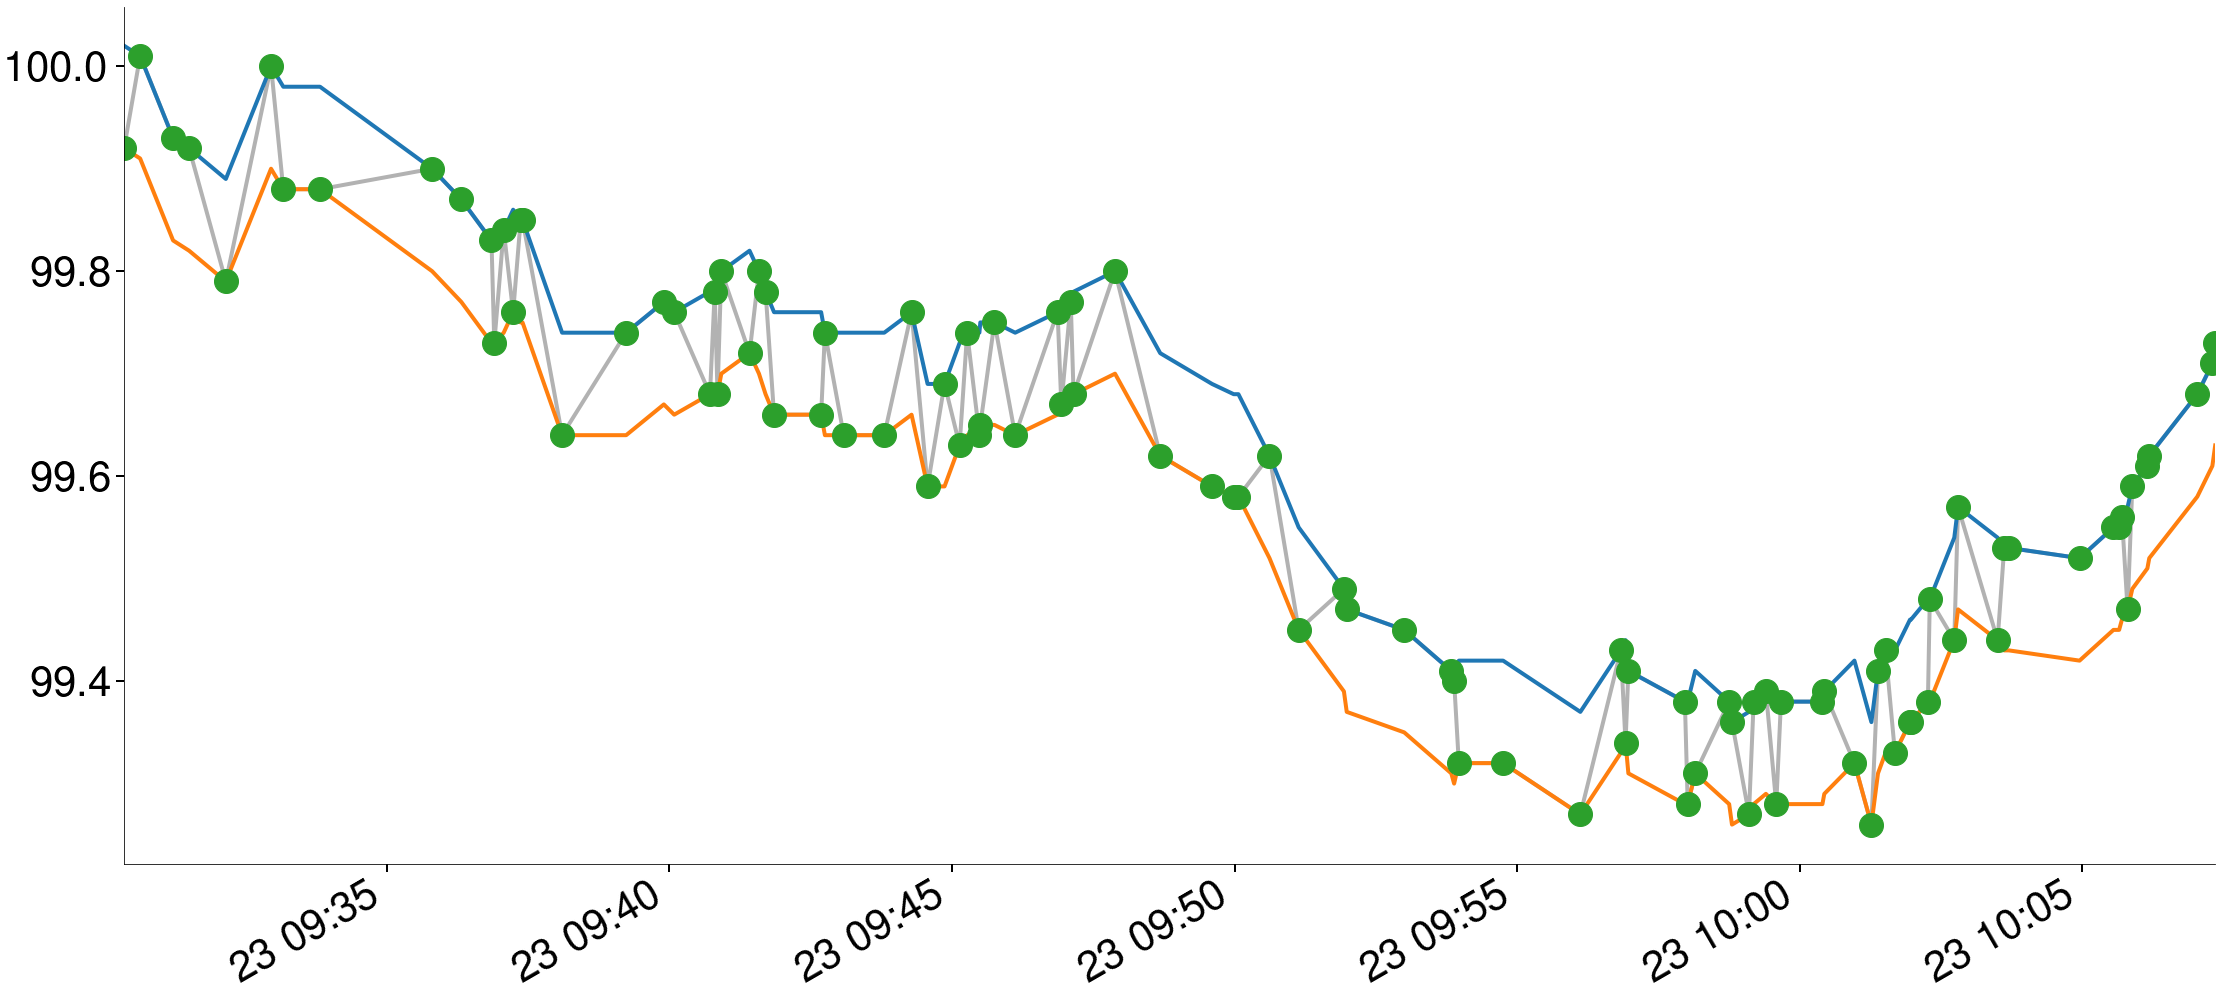

In [9]:
plot_trans(zoom=True)

# Volatilty Signature Plots

* Time-series average of Realized Variance

$$\overline{RV}_{t}^{(m)}=T^{-1}\sum_{t=1}^{T}RV_{t}^{(m)}$$

* Function of the number of samples $m$
* Look for inflection points

In [10]:
#def vsp():
#def plot_rv():
rv = defaultdict(list)
sp = 0.02
samp = [23400, 11700,  7800,  5850,  4680,  3900,  2925,  2600,  2340,
        1950,  1800,  1560,  1300,  1170,   975,   936,   900,   780,
         650,   600,   585,   520,   468,   450,   390,   360,   325,
         312,   300,   260,   234,   225,   200,   195,   180,   156,
         150,   130,   120,   117,   104,   100,    90,    78,    75,
          72,    65,    60,    52,    50,    45,    40,    39,    36,
          30,    26,    25,    24,    20,    18,    15,    13]
for j in range(100):
    e = mu/(252*m) + rg.standard_normal(23400) * np.sqrt(sigma**2 / (252 *m))
    lp = np.log(100) + np.cumsum(np.r_[0,e])
    
    mq = np.round(np.exp(lp),2)
    direct = 2*rg.integers(0,2,size=mq.shape[0])-1
    trans = mq + direct * sp
    p = np.log(trans)
    for i in samp:
        step = m // i
        _rv = (np.diff(p[::step])**2).sum()
        rv[step].append(_rv)
rv = pd.DataFrame(rv)

def vsp():
    mean_rv = np.log(rv).mean()
    mean_rv.name="Avg. Log RV"
    plot(mean_rv)
    ax = plt.gca()
    ax.plot(np.log(rv).T)
    for l in ax.lines[1:]:
        l.set_color("#bbbbbb")
        l.set_linewidth(1.5)
        l.set_zorder(-3)

# Simulated Data Signature Plot

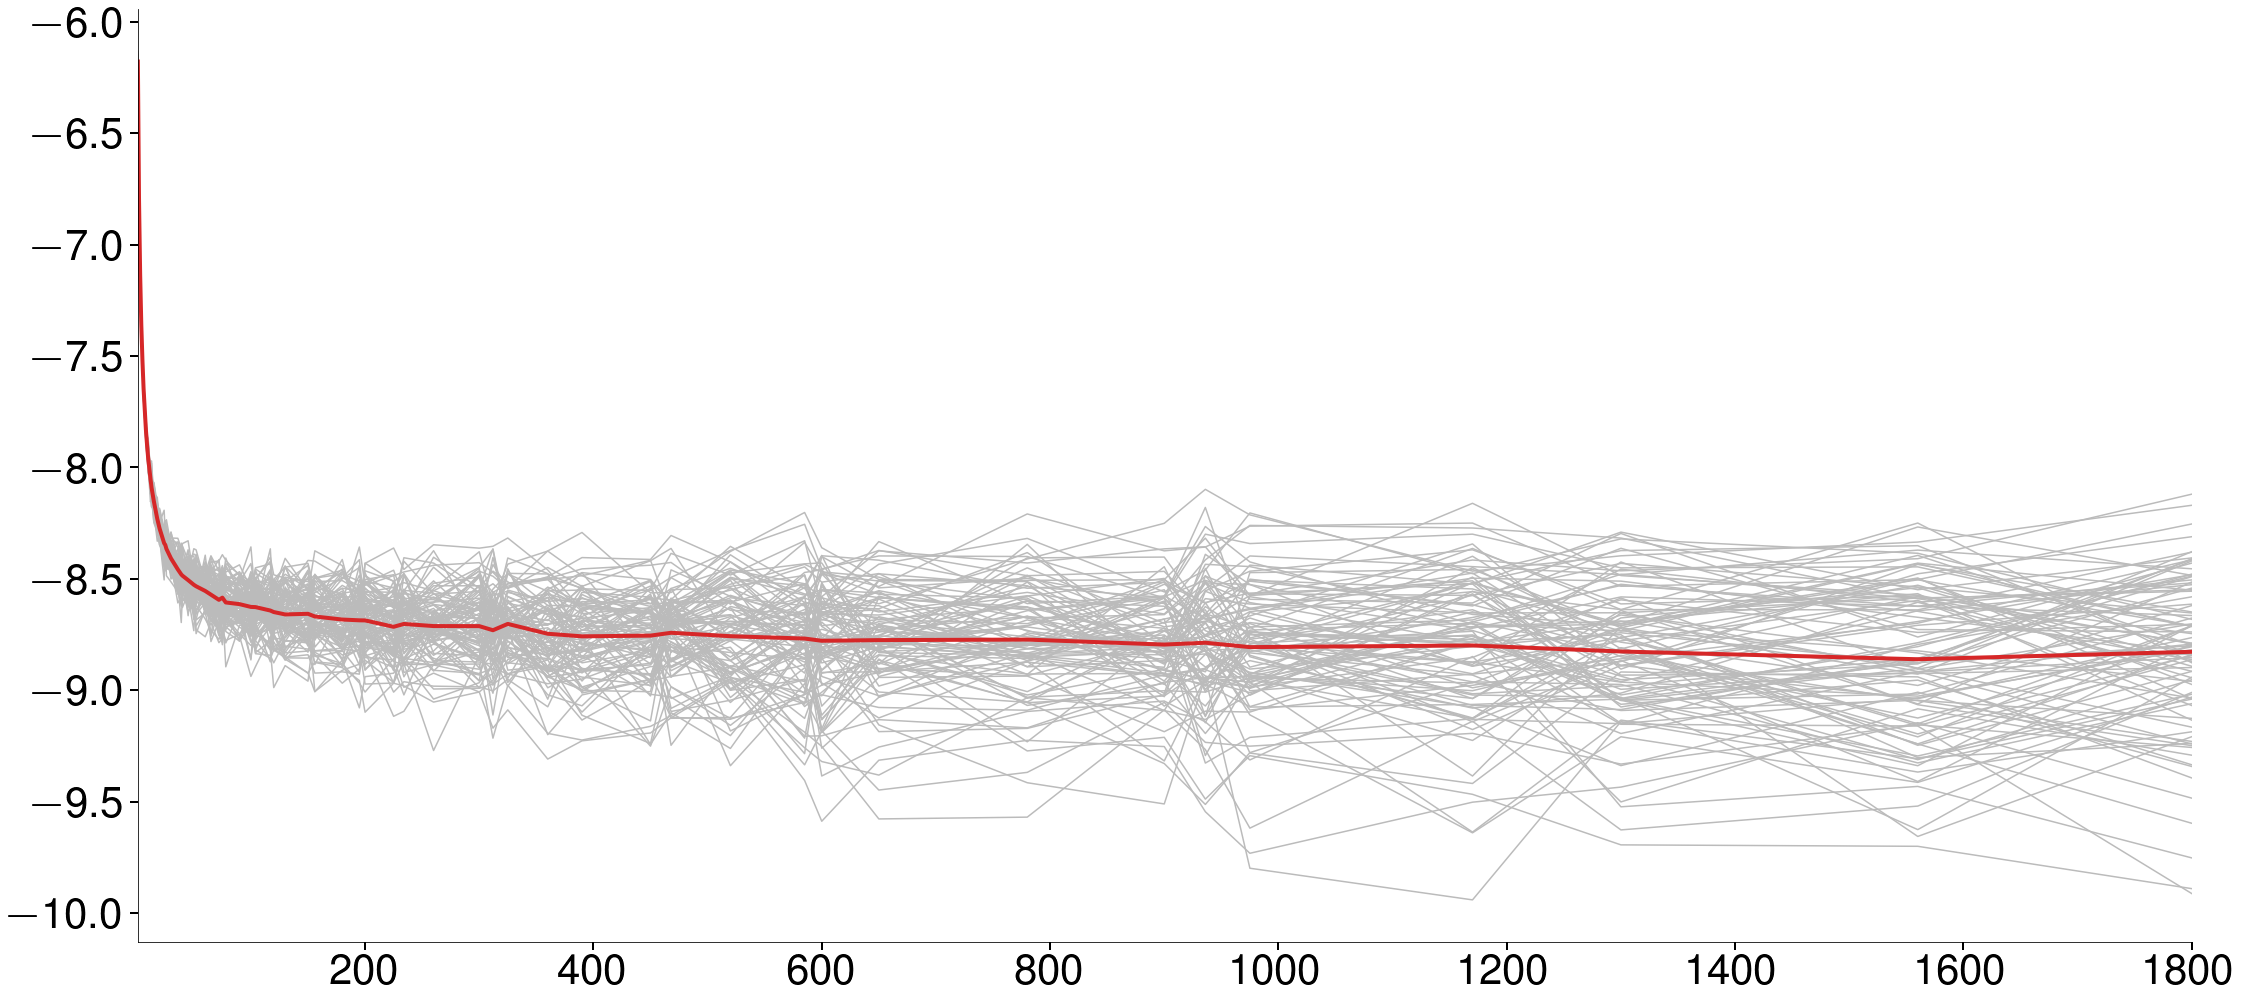

In [11]:
vsp()

# Sparse sampling and Subsampling

* Simple solution is to use sparse sampling
* Problem: there are many 5-minute returns between 9:30 and 16:00
* Solution: Use them all (or many since _all_ is overkill)
  * 9:30-9:35
  * 9:31:9:36
  * 9:32-9:37
  * ...
* Mild improvement in accuracy

# Robustifying Realized Variance

* Bid-ask bounce produces bias
* Best solution is to use an estimator that is robust to noise
$$RV_{t}^{AC1(m)}=\sum_{i=1}^{m}r_{i,t}^{2}+2\sum_{i=2}^{m}r_{i,t}r_{i-1,t}$$
* Removes first order bias
* Not consistent, need more lags for consistency
* _Realized Kernel_ is like the Newey-West estimator


In [12]:
#def vsp():
#def plot_rv():
rv = defaultdict(list)
sp = 0.02
samp = [23400, 11700,  7800,  5850,  4680,  3900,  2925,  2600,  2340,
        1950,  1800,  1560,  1300,  1170,   975,   936,   900,   780,
         650,   600,   585,   520,   468,   450,   390,   360,   325,
         312,   300,   260,   234,   225,   200,   195,   180,   156,
         150,   130,   120,   117,   104,   100,    90,    78,    75,
          72,    65,    60,    52,    50,    45,    40,    39,    36,
          30,    26,    25,    24,    20,    18,    15,    13]
for j in range(100):
    e = mu/(252*m) + rg.standard_normal(23400) * np.sqrt(sigma**2 / (252 *m))
    lp = np.log(100) + np.cumsum(np.r_[0,e])
    
    mq = np.round(np.exp(lp),2)
    direct = 2*rg.integers(0,2,size=mq.shape[0])-1
    trans = mq + direct * sp
    p = np.log(trans)
    for i in samp:
        step = m // i
        r = np.diff(p[::step])
        _rv = (r**2).sum() + 2 * (r[:-1]*r[1:]).sum()
        rv[step].append(_rv)
rv = pd.DataFrame(rv)

def vsp_ac1():
    mean_rv = np.log(rv).mean()
    mean_rv.name="Avg. Log RV"
    plot(mean_rv)
    ax = plt.gca()
    ax.plot(np.log(rv).T)
    for l in ax.lines[1:]:
        l.set_color("#bbbbbb")
        l.set_linewidth(1.5)
        l.set_zorder(-3)

# AC1 Volatility Signature Plot

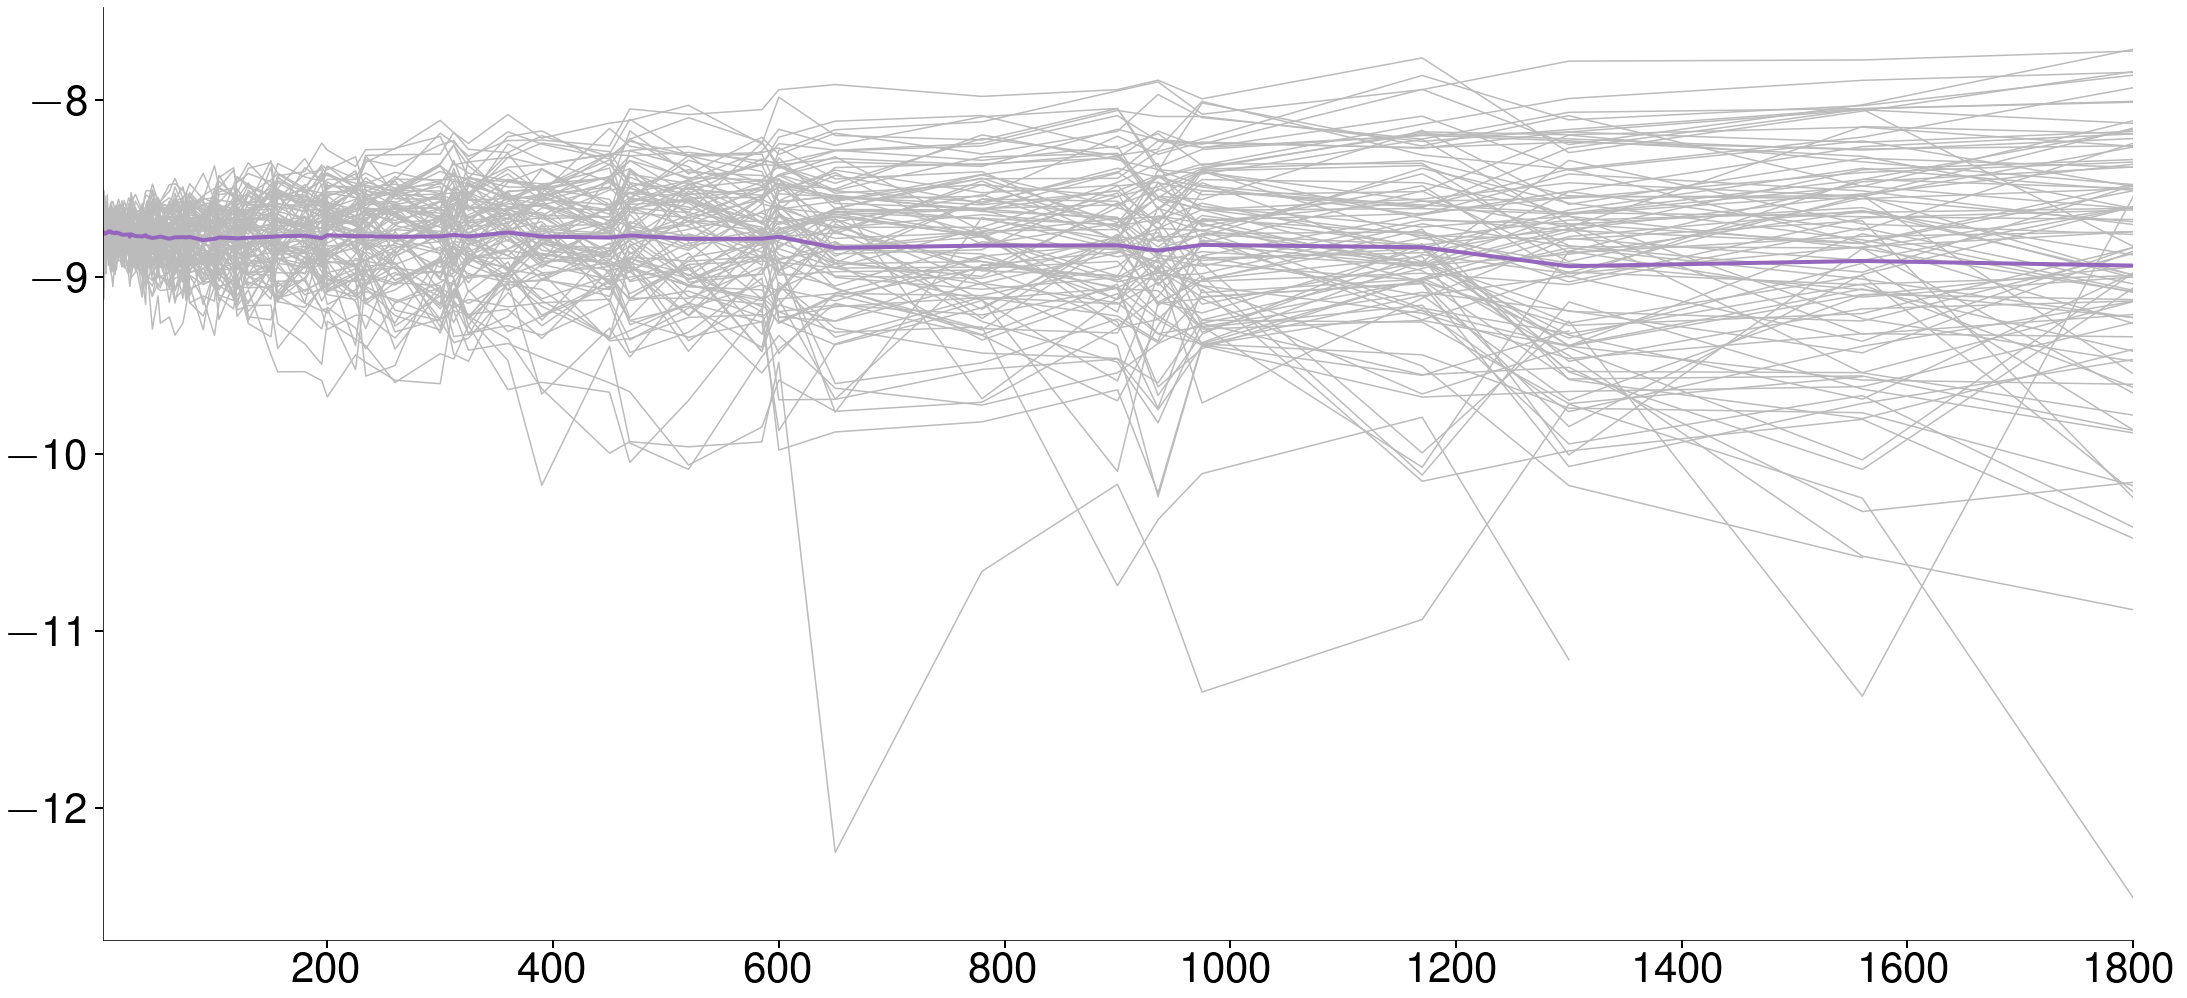

In [13]:
vsp_ac1()

# Realized Variance of the S&P 500

* SPY is an ultra-liquid ETF that tracks the S&P 500
* Actual data from 2007 until 2018
* Cleaned and reduced to 1-second data

In [14]:
import copy
from datetime import datetime
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import mfe

colors = copy.deepcopy(mfe.colors)
colors.append((0.0, 0.0, 0.0))

with pd.HDFStore("code/consolidated-spy.h5", "r") as h5file:
    spy = h5file.get("spy")

yyyymmdd = 10000 * spy.index.year + 100 * spy.index.month + spy.index.day
df = pd.DataFrame(spy)
hhmmss = df.index.hour * 10000 + 100 * df.index.minute + df.index.second
mi = pd.MultiIndex.from_arrays([yyyymmdd, hhmmss])
df.index = mi
spy_df = df.price.unstack().T
spy_df = spy_df.ffill().bfill()
# RV difference schemes
# AC1 same
# VSP

In [15]:
p = np.log(np.asarray(spy_df))

samp = [23400, 4680,  1560,  390]
sp500_rv = {}
sp500_rv_ac1 = {}
idx = [dt.datetime(d//10000, (d//100)%100, d%100) for d in spy_df.columns]
for s in samp:
    step = 23400 // s
    _p = p[::step]
    r = _p[1:] - _p[:-1]
    sp500_rv[s] = pd.Series((r**2).sum(0),index=idx)
    sp500_rv_ac1[s] = pd.Series((r**2).sum(0) + 2 * (r[1:]*r[:-1]).sum(0),index=idx)
sp500_rv =pd.DataFrame(sp500_rv)    
sp500_rv_ac1 =pd.DataFrame(sp500_rv_ac1)

def plot_sp500(col):
    a = sp500_rv.iloc[:,col]
    b = sp500_rv_ac1.iloc[:,col]
    c = 100*np.sqrt(252*pd.concat([a,b],axis=1))
    c.columns = ["$RV$",'$RV^{AC1}$']
    plot(c)

# 1-second Sampling

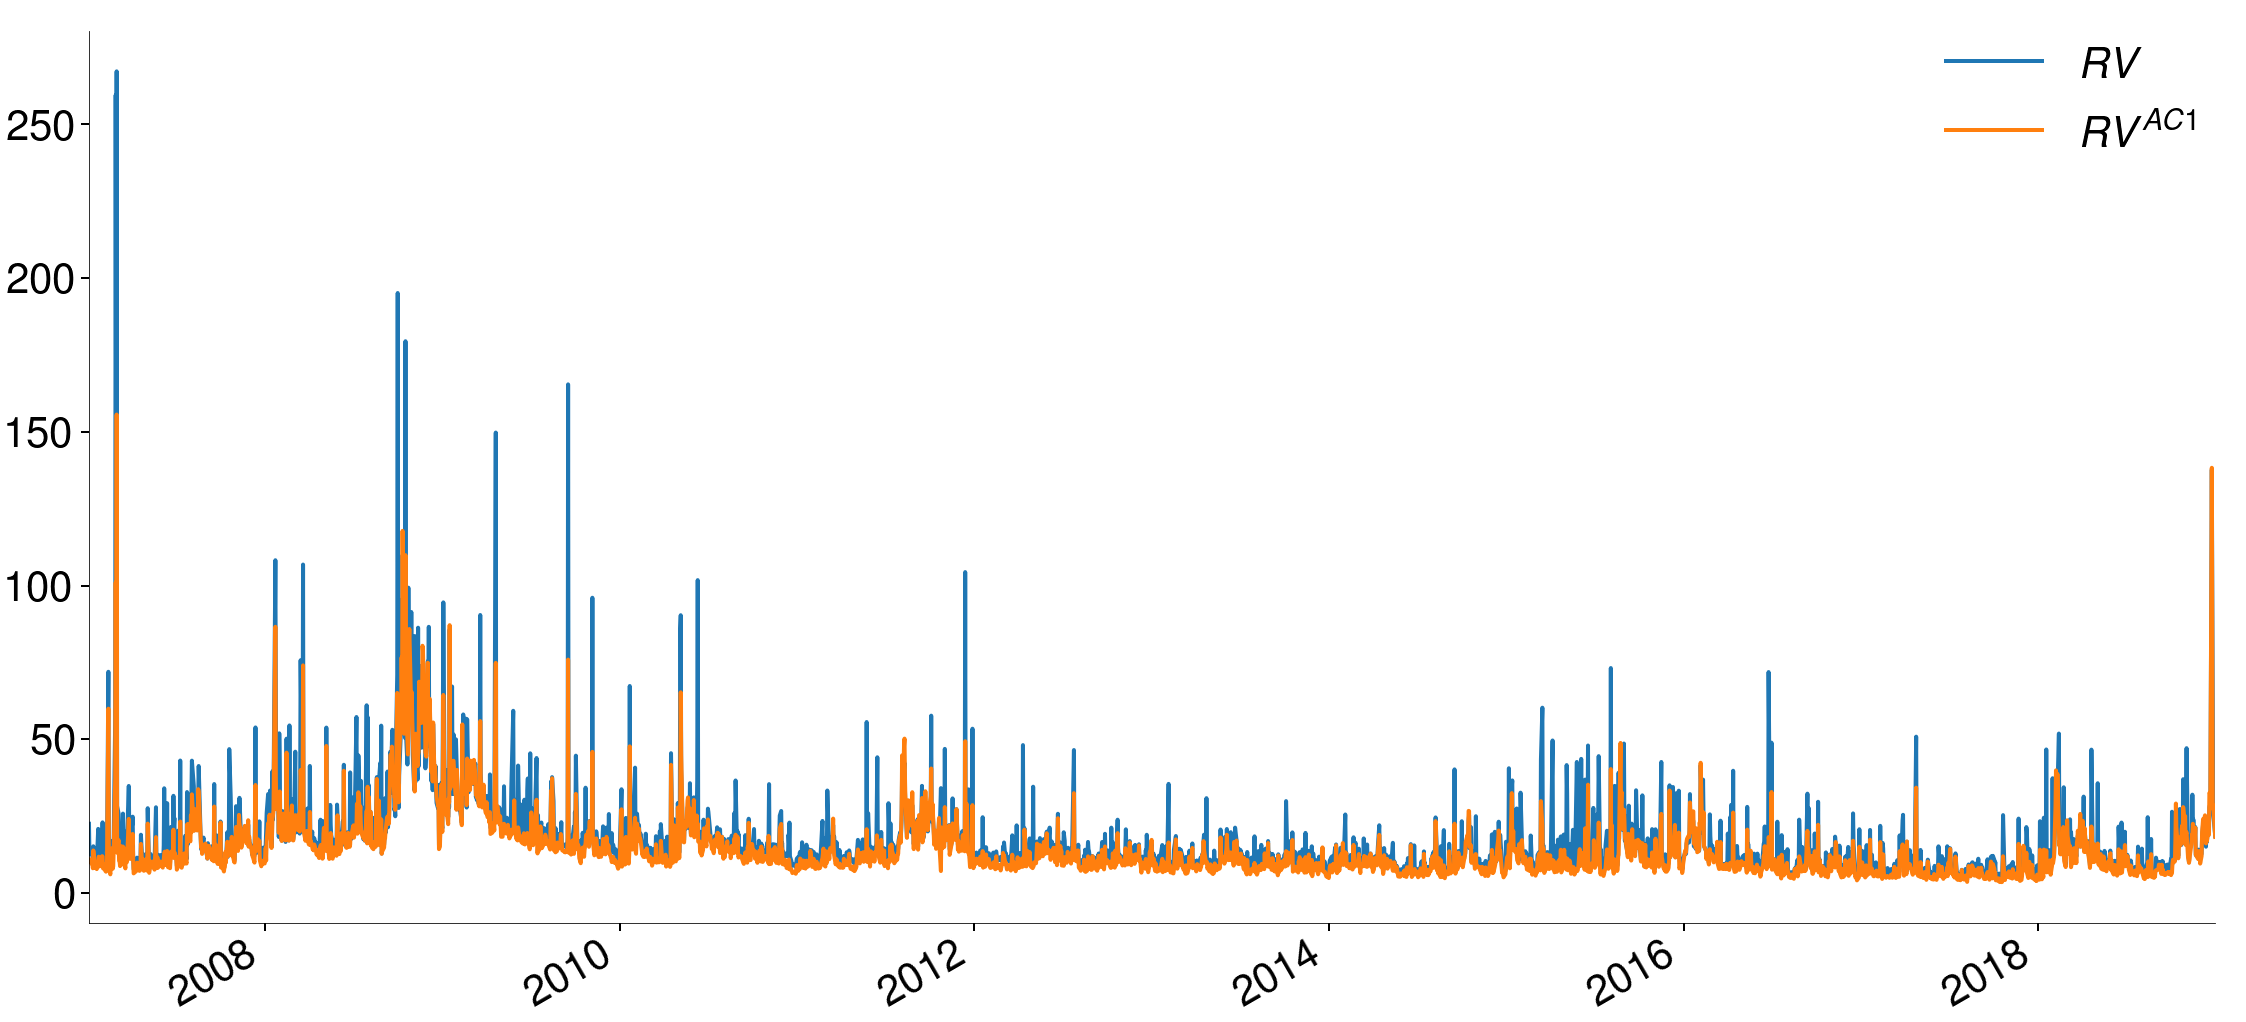

In [16]:
plot_sp500(0)

# 5-second Sampling

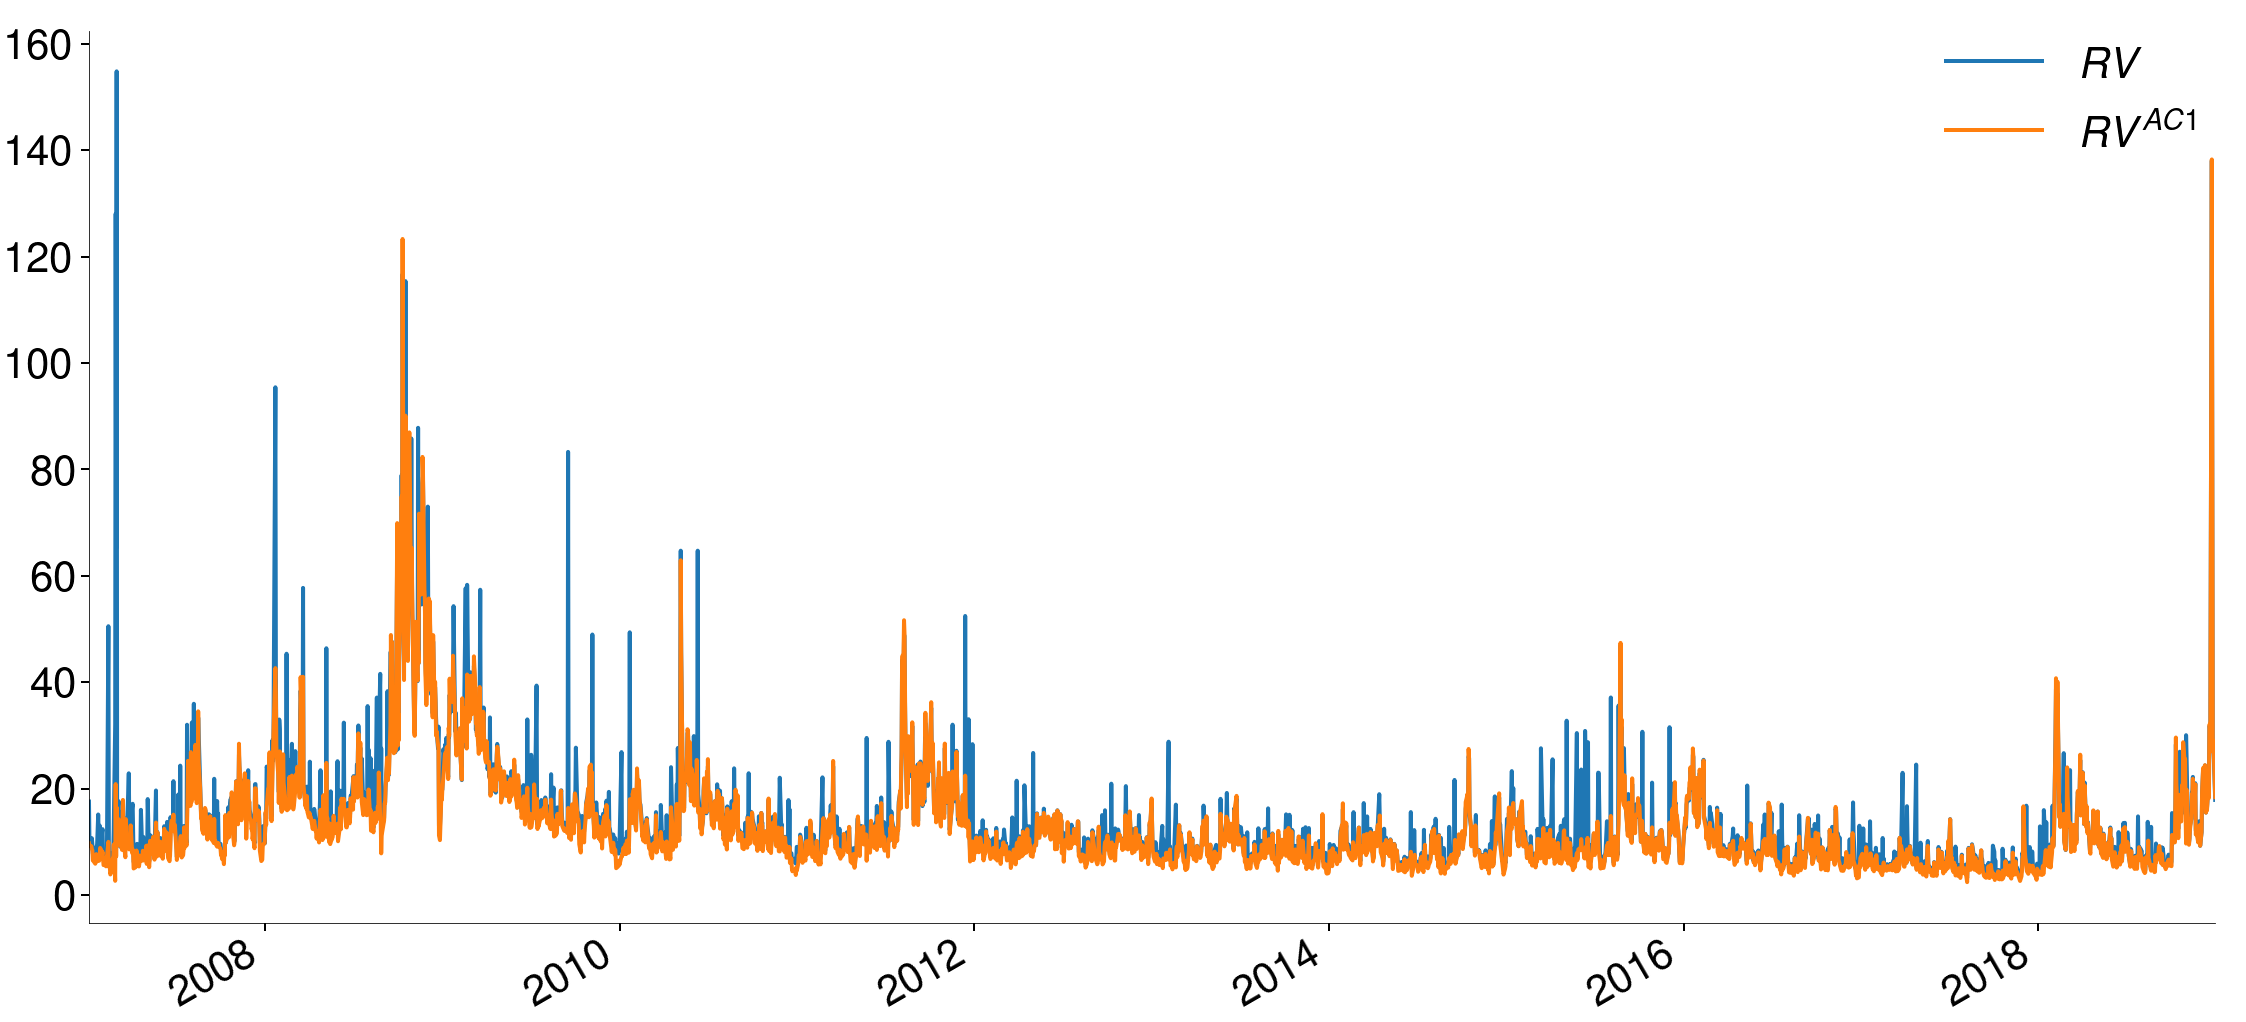

In [17]:
plot_sp500(1)

# 15-second Sampling

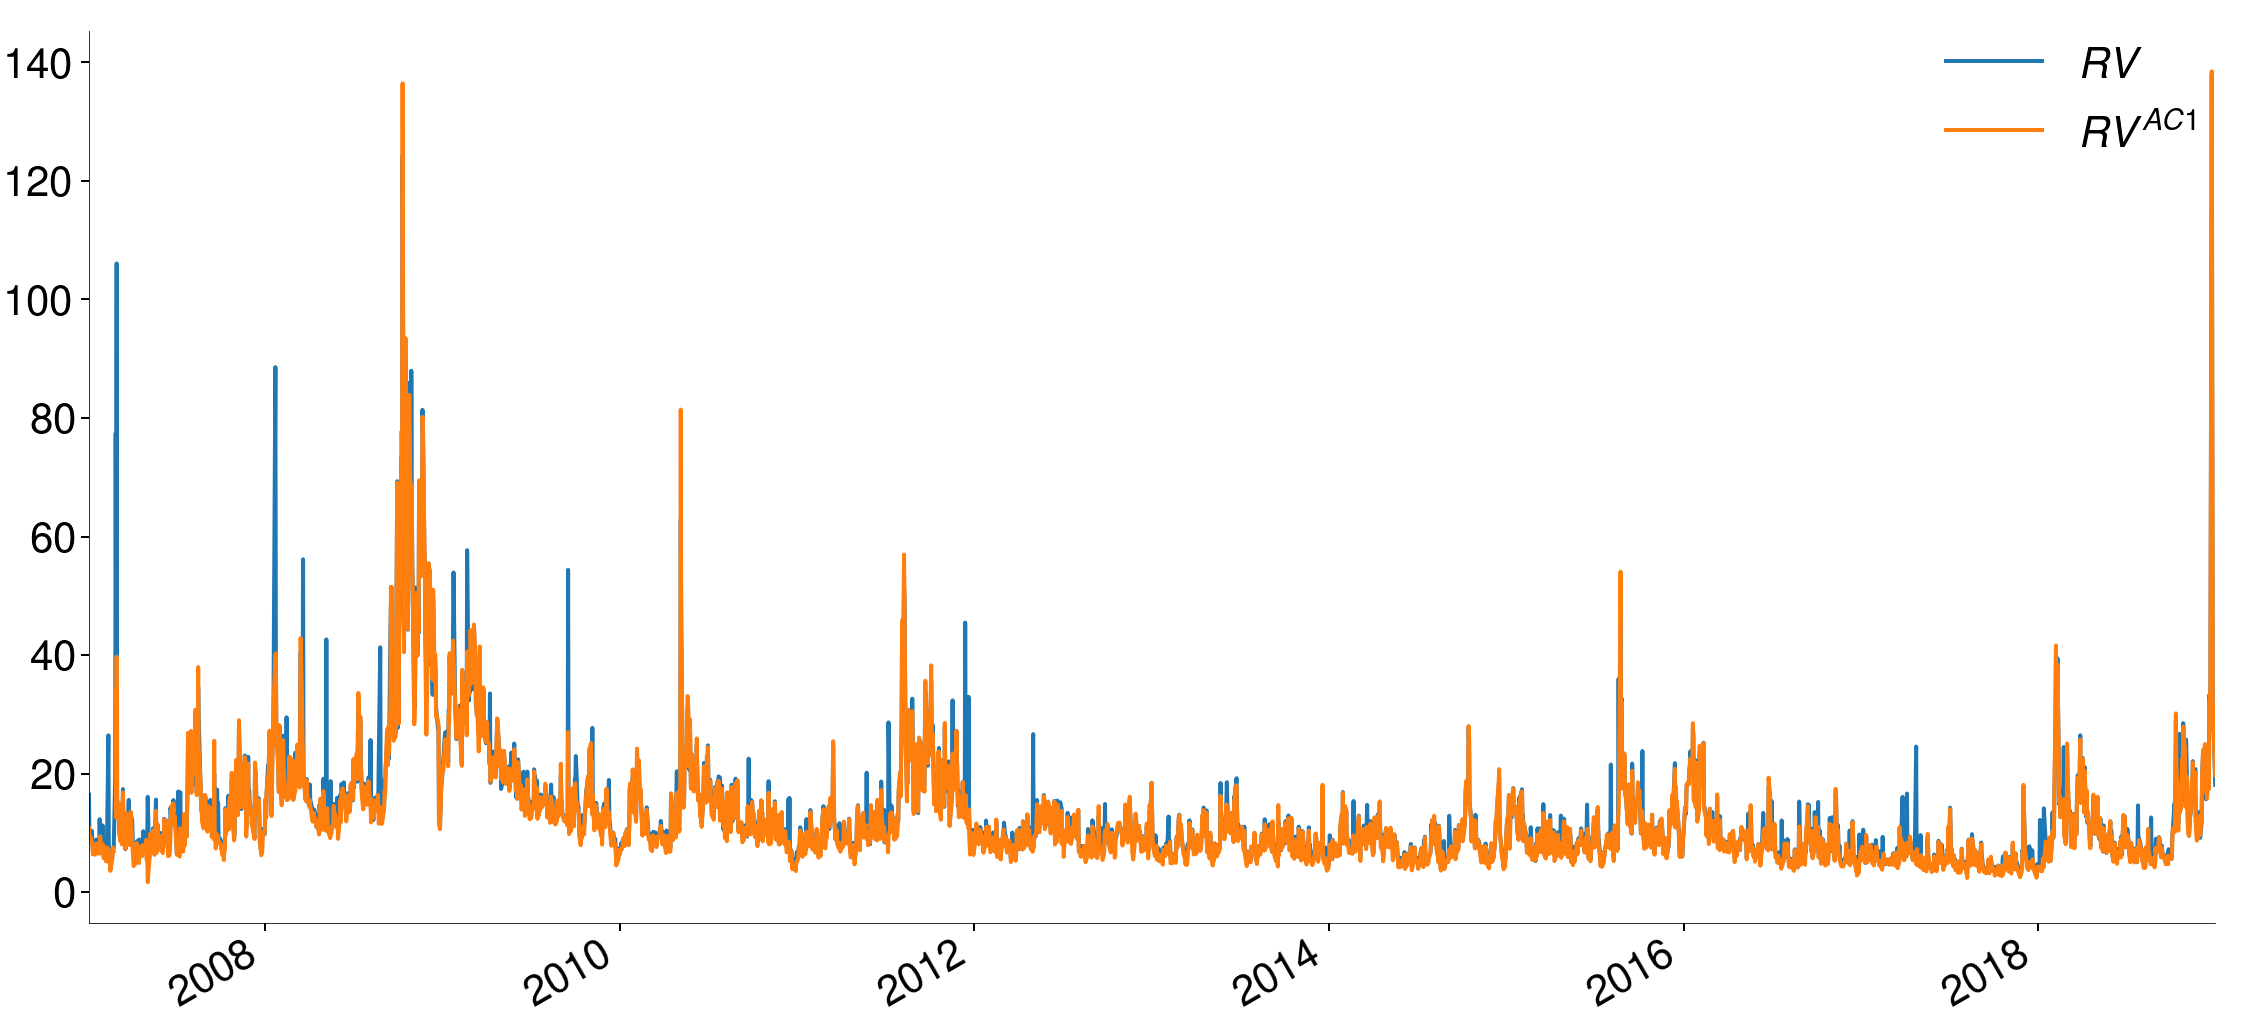

In [18]:
plot_sp500(2)

# 1-minute Sampling

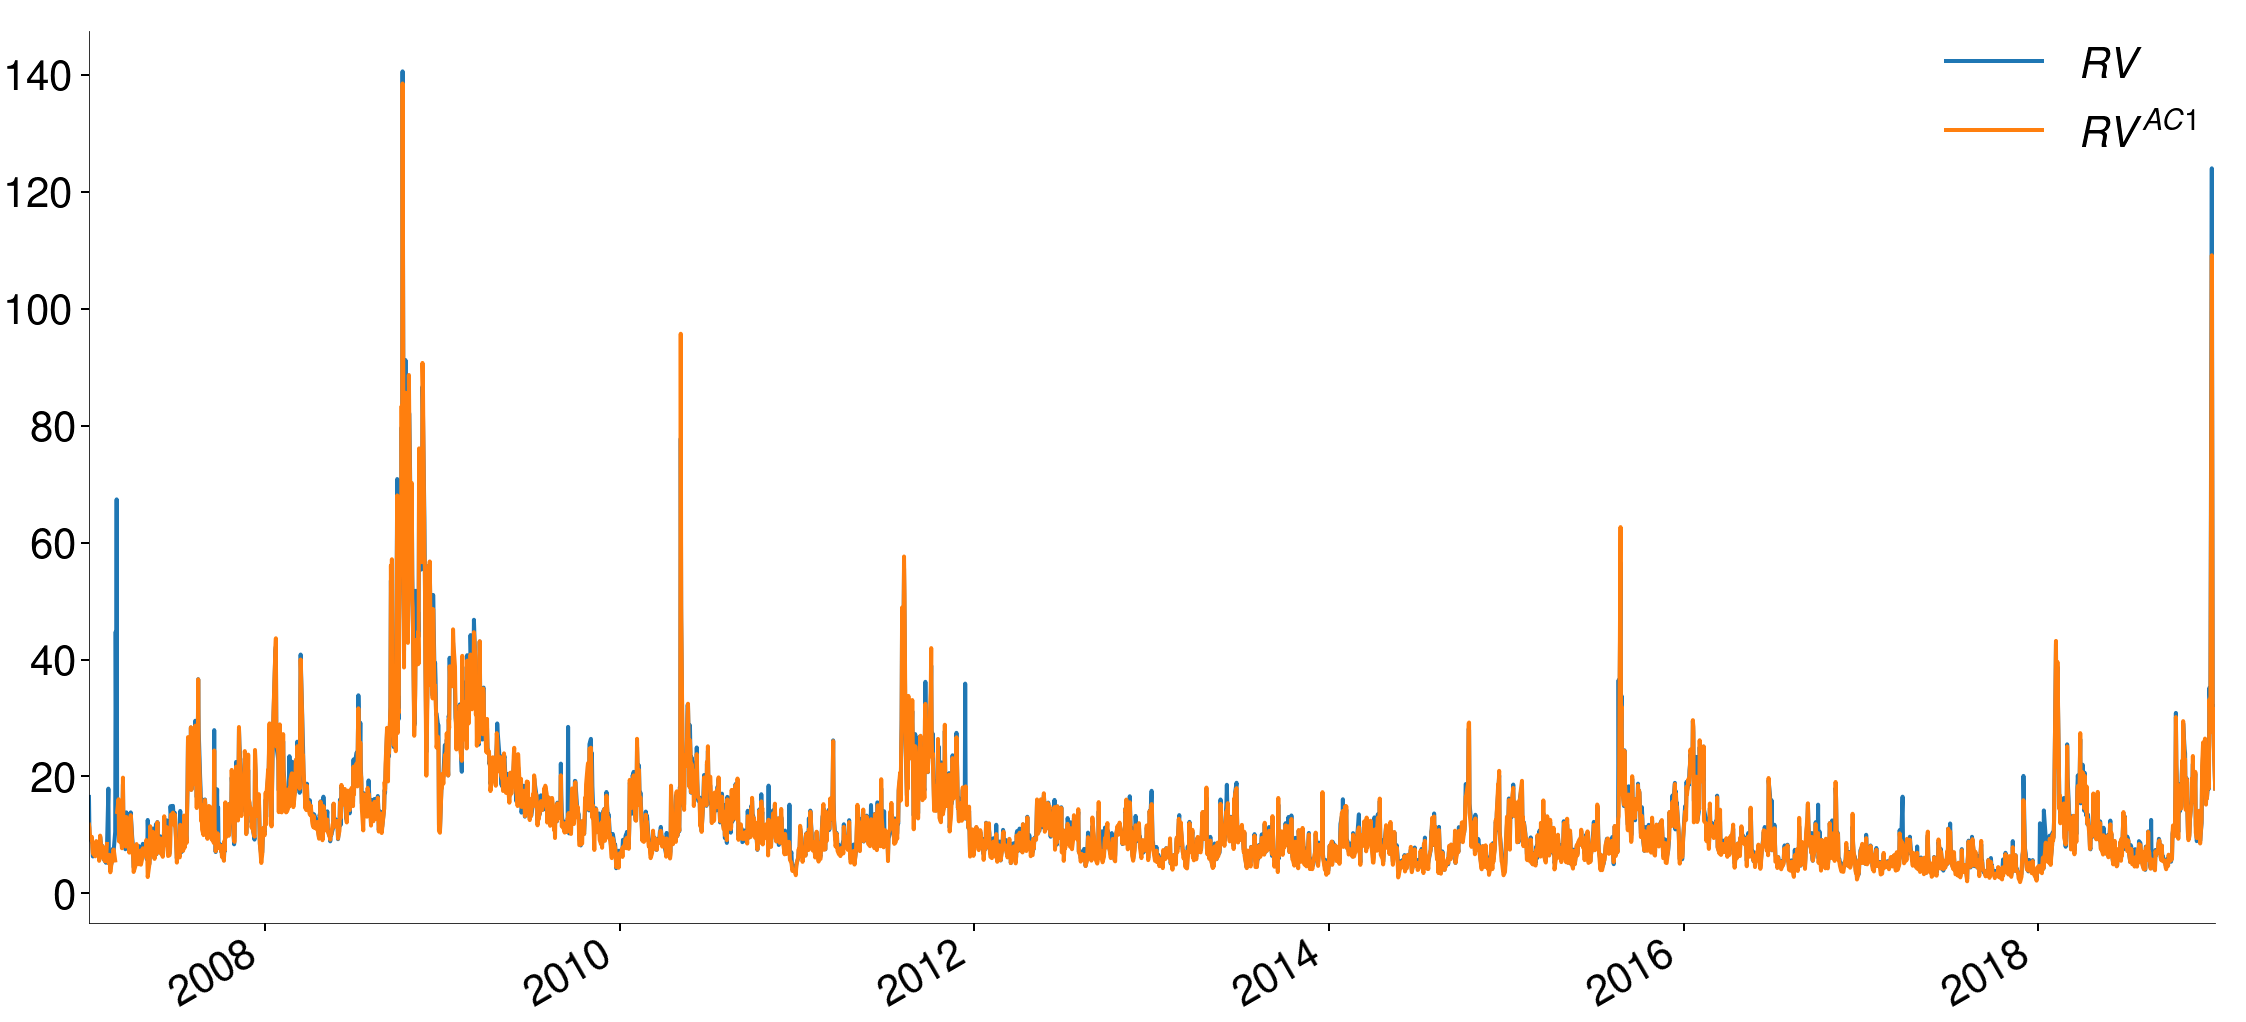

In [19]:
plot_sp500(3)

In [20]:
samp = [23400, 11700,  7800,  5850,  4680,  3900,  2925,  2600,  2340,
        1950,  1800,  1560,  1300,  1170,   975,   936,   900,   780,
         650,   600,   585,   520,   468,   450,   390,   360,   325,
         312,   300,   260,   234,   225,   200,   195,   180,   156,
         150,   130,   120,   117,   104,   100,    90,    78,    75,
          72,    65,    60,    52,    50,    45,    40,    39,    36,
          30,    26,    25,    24,    20,    18,    15,    13]
sp500_vsp = {}
sp500_vsp_ac1 = {}
for s in samp:
    step = 23400 // s
    _p = p[::step]
    r = _p[1:] - _p[:-1]
    sp500_vsp[s] = pd.Series((r**2).sum(0),index=idx).mean(0)
    sp500_vsp_ac1[s] = pd.Series((r**2).sum(0) + 2 * (r[1:]*r[:-1]).sum(0),index=idx).mean(0)
sp500_vsp = pd.Series(sp500_vsp)
sp500_vsp_ac1 = pd.Series(sp500_vsp_ac1)


In [21]:
def sp500_plot_vsp(zoom=False):
    df = pd.concat([sp500_vsp, sp500_vsp_ac1],1)
    df.columns = ["$RV$", "$RV^{AC1}$"]
    df.index = 23400 // df.index
    if zoom:
        df=df.iloc[df.index <= 60]
    plot(np.log(df))
    ax = plt.gca()
    for l in ax.lines:
        l.set_linestyle("none")
        l.set_marker("o")
        l.set_markersize(24)

# S&P 500 Volatility Signature Plot

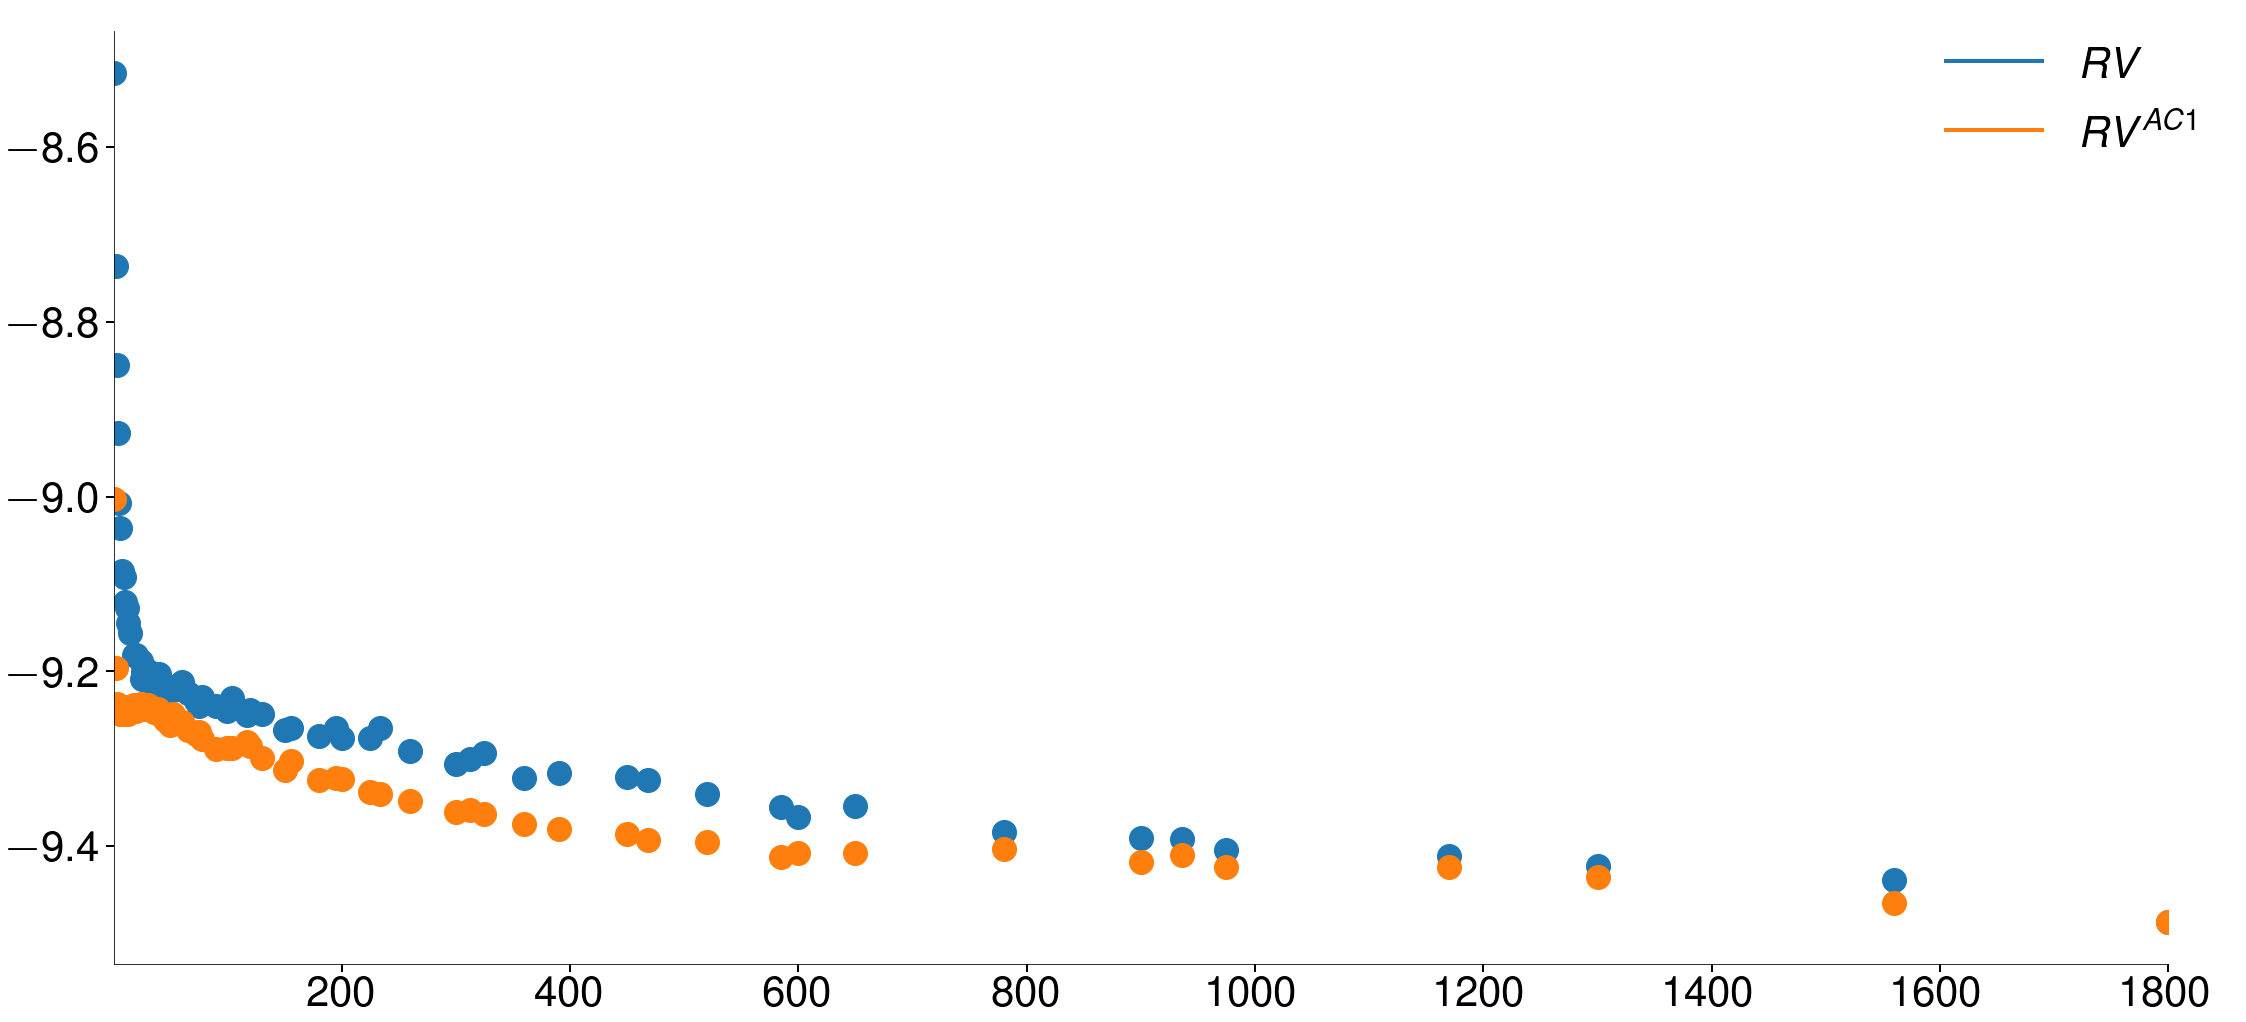

In [22]:
sp500_plot_vsp()

# Sub 1-minute Signature

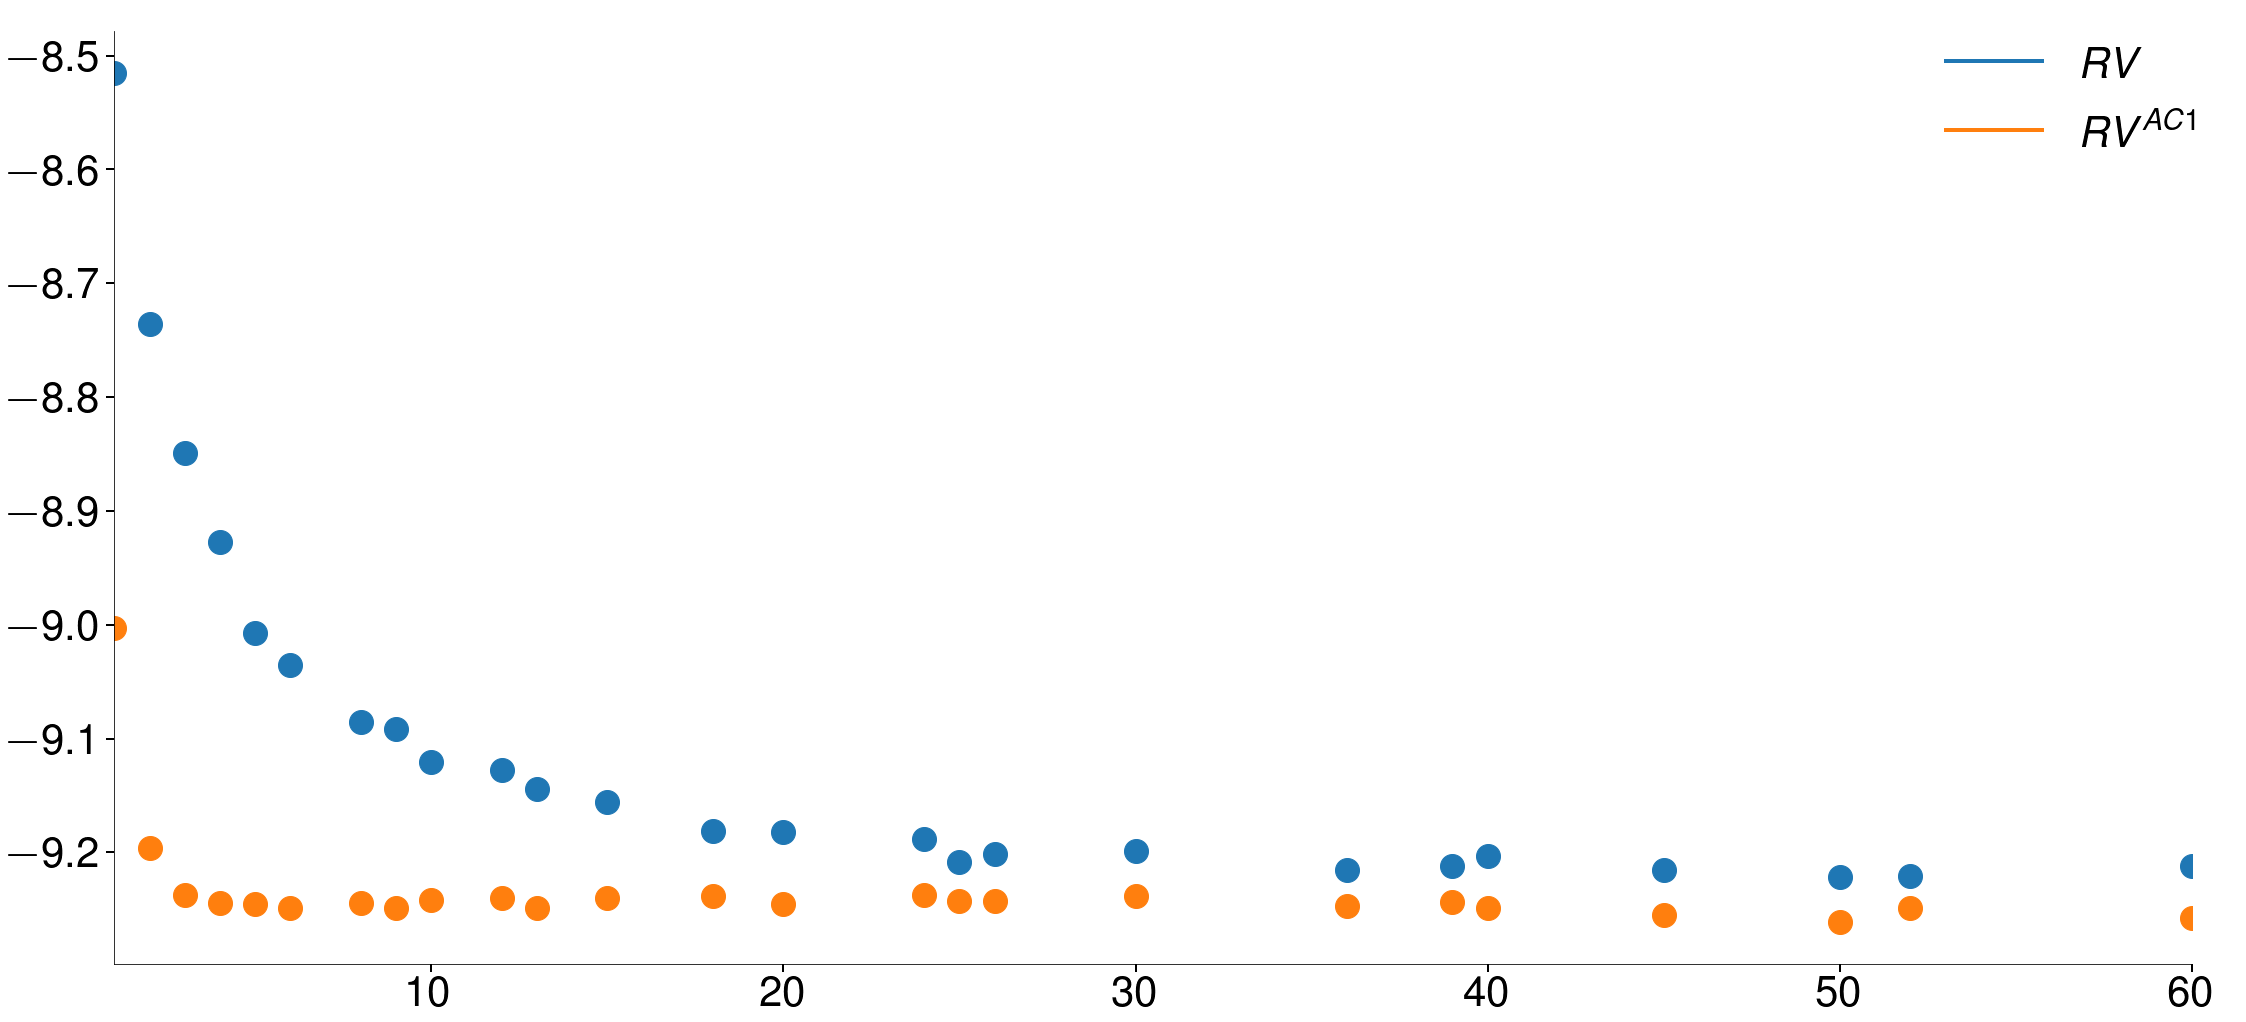

In [23]:
sp500_plot_vsp(zoom=True)

# BTC Realized Variance

* BTC is traded in many markets
* Data from Coinbase
* $RV$ works very well in modern assets like BTC



In [24]:
btc = pd.read_hdf("./code/btc.h5","btc")
def plot_btc_vsp():
    vsp = {}
    for col in btc:
        if not col.startswith("rv"):
            continue
        s = int(int(col.split("rv")[1][:-1]))
        vsp[s] = btc[col].mean()
    vsp = pd.Series(vsp)
    plot(vsp)

# BTC Volatility Signature Plot (Levels)

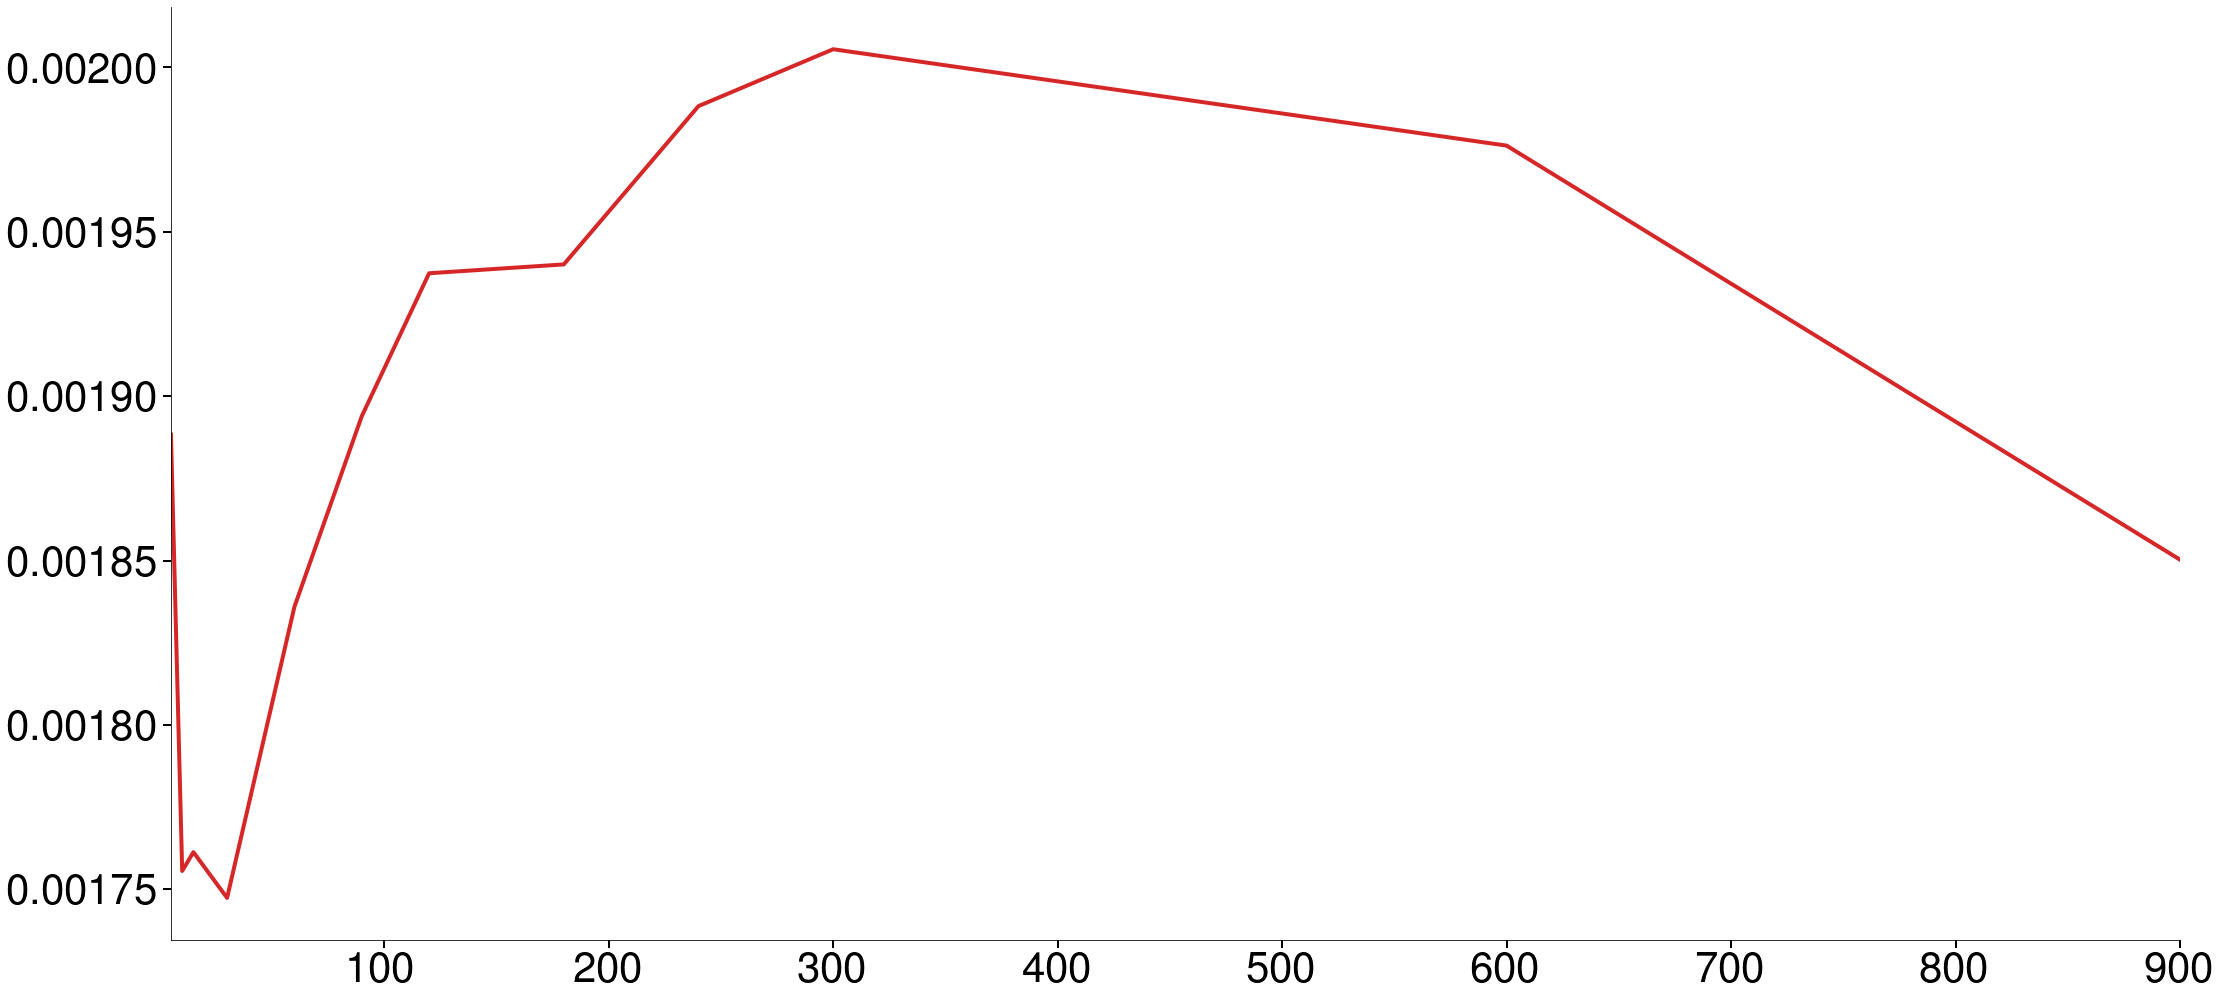

In [25]:
plot_btc_vsp()

In [26]:
def plot_btc(col):
    sub = btc[["rv5s","rv15s","rv60s"]]
    plot(100*np.sqrt(252*sub.iloc[:,col]))

# 5-second $RV$

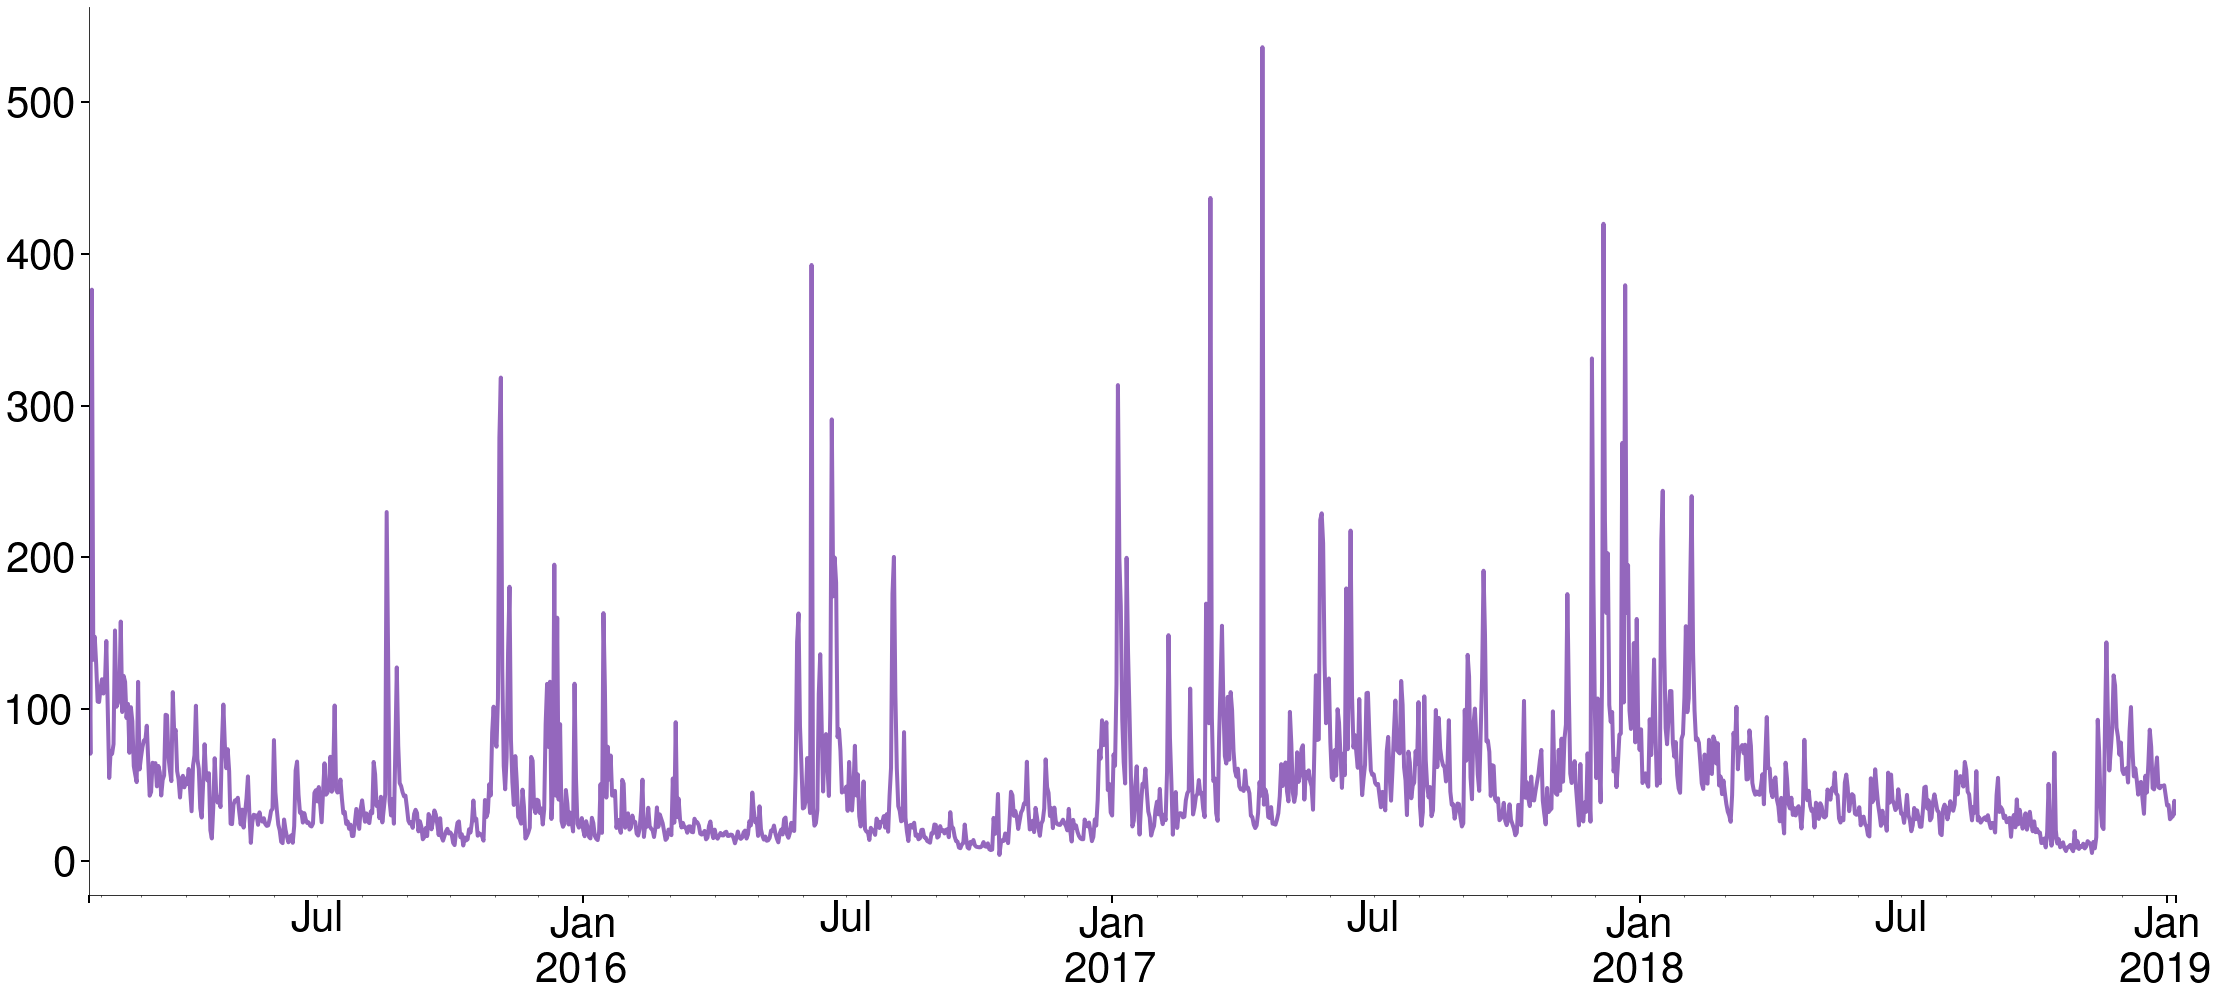

In [27]:
plot_btc(0)

# 15-second $RV$

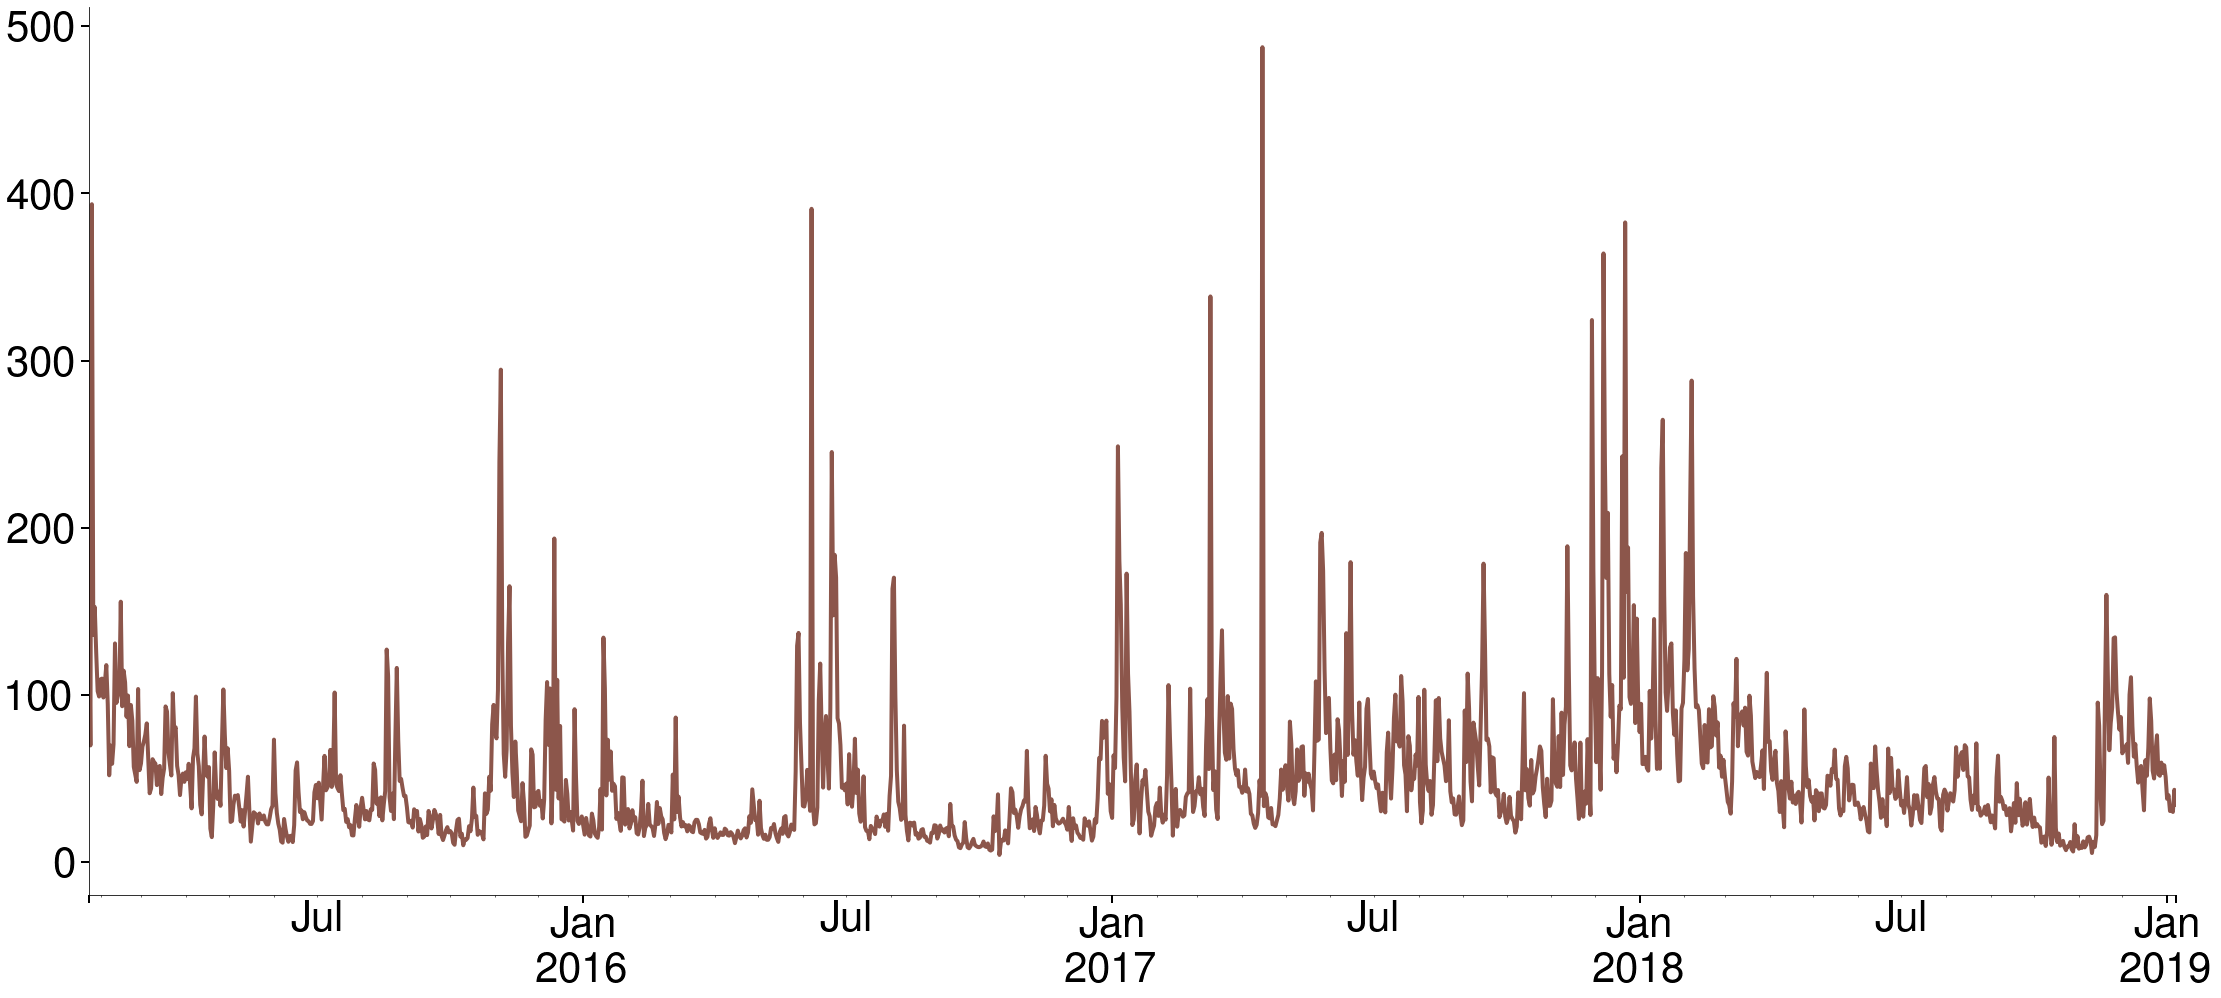

In [28]:
plot_btc(1)

# 60-second $RV$

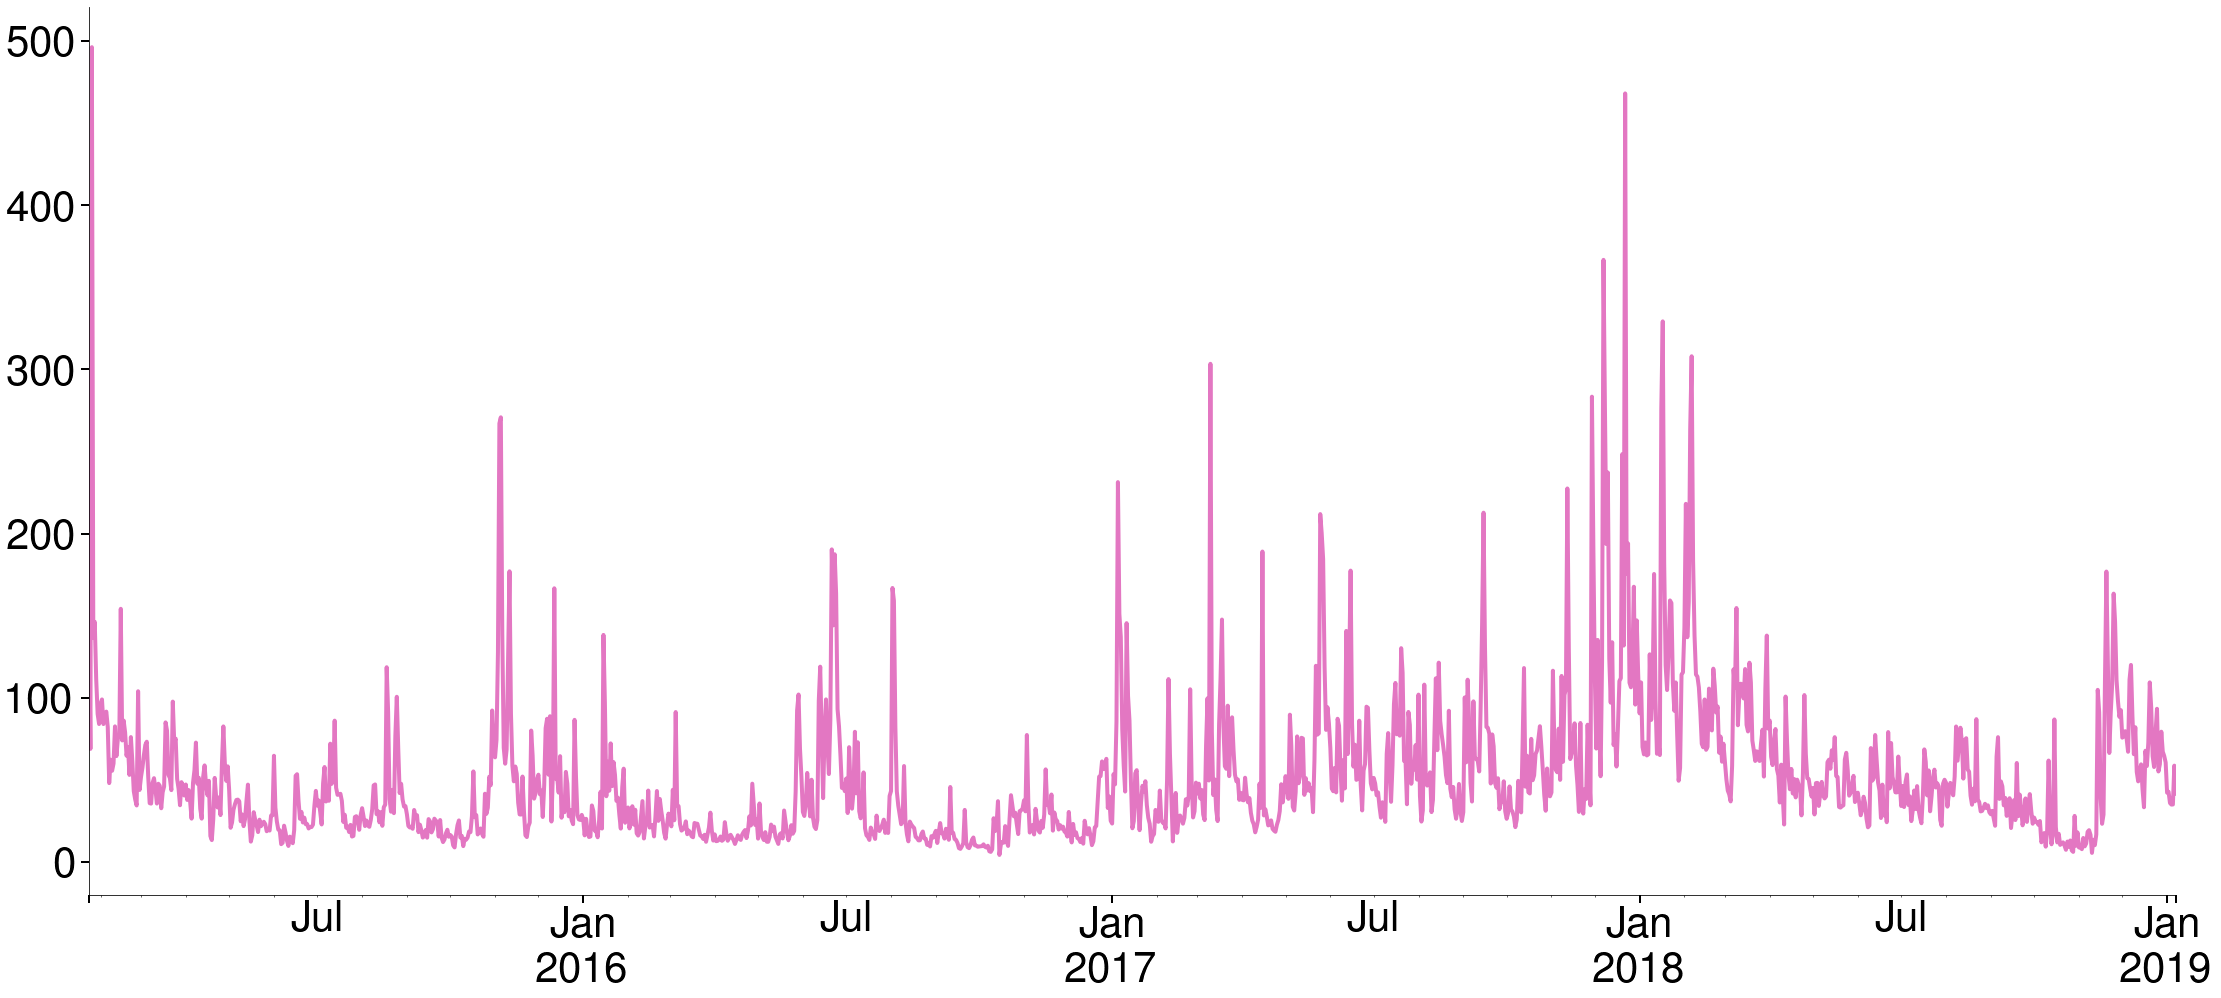

In [29]:
plot_btc(2)

# Modeling Realized Variance

* Treat as Observable and use ARMA
  * Heterogeneous autoregression (HAR)
* Multiplicative Error Model (MEM)

# HAR Models

* Restricted AR(22) in levels 

$$RV_{t}=\phi_{0}+\phi_{1}RV_{t-1}+\phi_{5}\overline{RV}_{5,t-1}+\phi_{22}\overline{RV}_{22,t-1}+\epsilon_{t}$$

* Or in logs 

$$\ln RV_{t}=\phi_{0}+\phi_{1}\ln RV_{t-1}+\phi_{5}\ln\overline{RV}_{5,t-1}+\phi_{22}\ln\overline{RV}_{22,t-1}+\epsilon_{t}$$

* Uses a $j$ lag moving average 

$$\overline{RV}_{j,t-1}=j^{-1}\sum_{i=1}^{j}RV_{t-i}$$



# HAR in levels

In [30]:
sp500_60s = sp500_rv.iloc[:,3]
sp500_60s.name = "rv"
from arch.univariate import HARX

In [31]:
summary(HARX(sp500_60s, lags=[1,5,22], rescale=False).fit())

# HAR in logs

In [32]:
ln_sp500_60s = np.log(sp500_60s)
ln_sp500_60s.name = "ln RV"

In [33]:
summary(HARX(ln_sp500_60s, lags=[1,5,22], rescale=False).fit())

# HAR Weights

In [34]:
har = HARX(ln_sp500_60s, lags=[1,5,22], rescale=False).fit()
def har_weights():
    p = np.array(har.params.iloc[1:4])
    w = np.zeros(22)
    w[0] = p[0]
    w[:5] += p[1]/5
    w[:] += p[2]/22
    plot(pd.Series(w,index=np.arange(1,23)))
    ax = plt.gca()
    ax.set_xticks(np.arange(1,23))


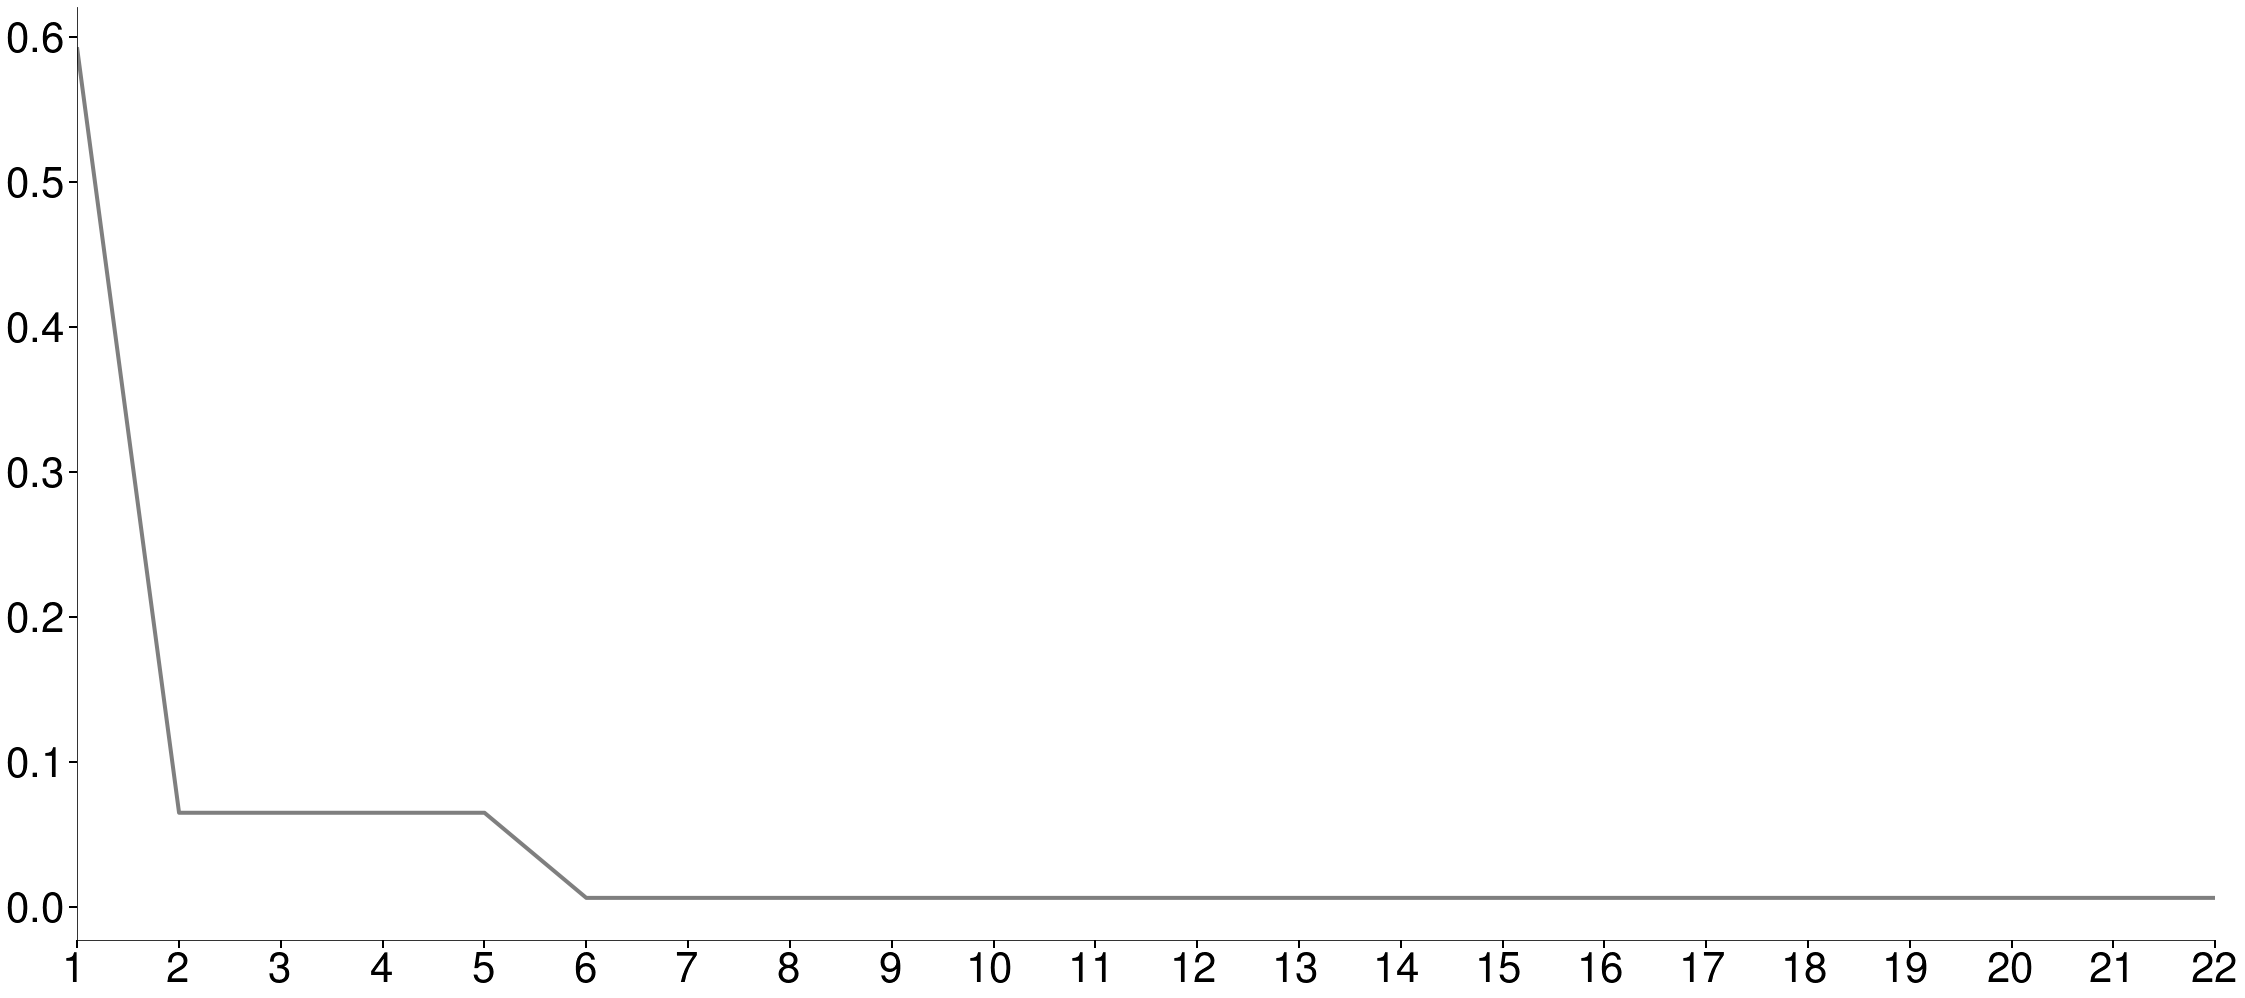

In [35]:
har_weights()

# Forecasting after $\ln$

* When forecasting after using $\ln$ two options
    * Treat errors are normal and use log-normal to forecast
    * Exponential forecast and use _median_ to forecast
* Log-normal uses
$$ \mathrm{E}[Y_{t+h|t}] = \exp\left(\mathrm{E}_{t}[\ln Y_{t+h}] + \frac{\mathrm{V}_{t}[\ln Y_{t+h}]}{2}\right) $$

# Constructing Forecasts

In [36]:
fcasts = har.forecast(horizon=10)
df = pd.concat([fcasts.mean.iloc[-1], fcasts.variance.iloc[-1]],1)
df.columns = ["Mean","Var"]
df

Mean       Var
h.01 -8.557239  0.271689
h.02 -8.539637  0.366659
h.03 -8.553043  0.413345
h.04 -8.592687  0.446340
h.05 -8.628181  0.477080
h.06 -8.626100  0.510716
h.07 -8.630428  0.539273
h.08 -8.639355  0.563083
h.09 -8.651733  0.583799
h.10 -8.661265  0.602613

# Finishing Forecasts

In [37]:
both = pd.concat([np.exp(df.Mean + df.Var/2), np.exp(df.Mean)],1)
both.columns = ["Log-normal","Median"]
both

Log-normal    Median
h.01    0.000220  0.000192
h.02    0.000235  0.000196
h.03    0.000237  0.000193
h.04    0.000232  0.000185
h.05    0.000227  0.000179
h.06    0.000232  0.000179
h.07    0.000234  0.000179
h.08    0.000235  0.000177
h.09    0.000234  0.000175
h.10    0.000234  0.000173

# Visualizing forecasts

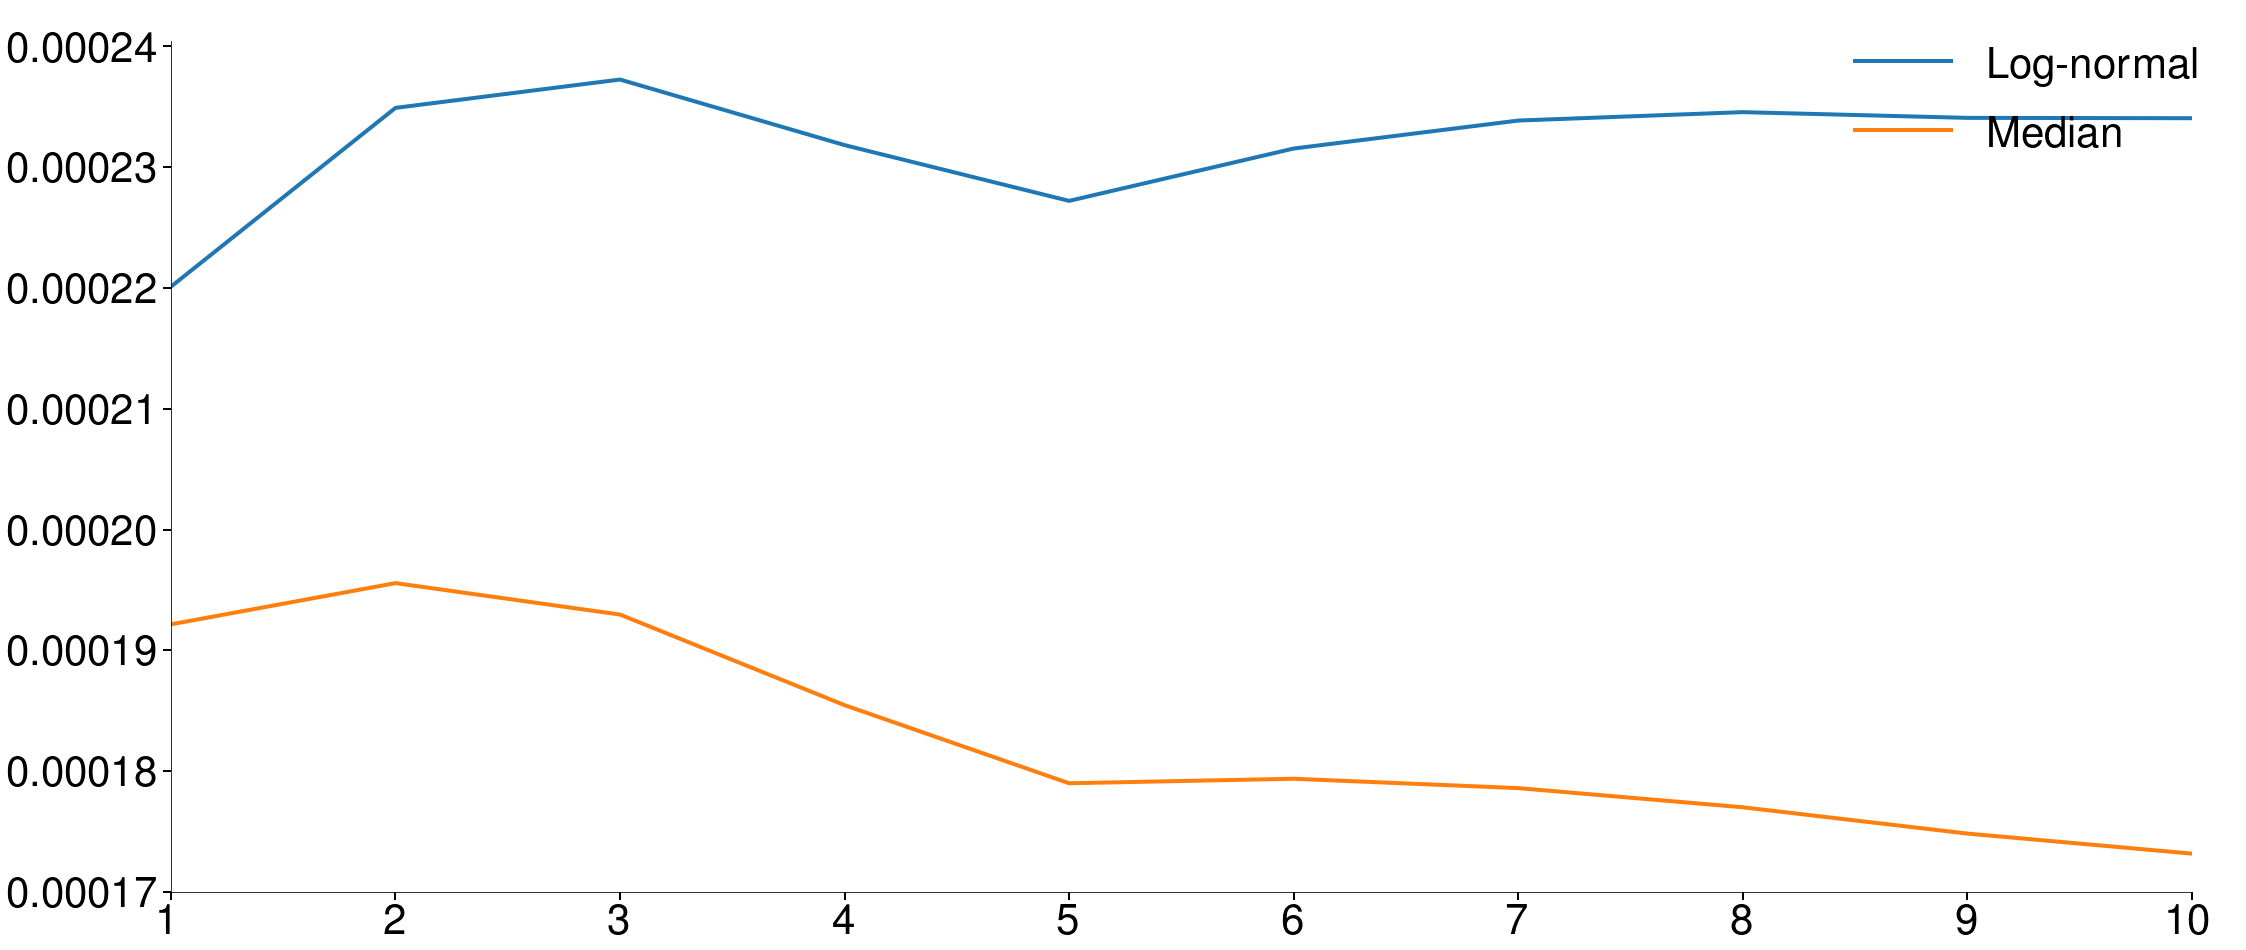

In [38]:
both.index = np.arange(1,11)
plot(both, 14)

# MEM Models

* MEMs specify the mean of a process as $\mu_{t}\times\psi_{t}$ where $\psi_{t}$ is a mean 1 shock. 
* ARCH models are special cases of a non-negative MEM model 
* Easy to model RV using existing ARCH mdoes 

1. Construct
$$\tilde{r}_{t}=\mathrm{\text{sign}}\left(r_{t}\right)\sqrt{RV_{t}} $$

2. Use standard ARCH model building to construct a model for $\tilde{r}_{t}$
$$\sigma_{t}^{2}=\omega+\alpha_{1}\tilde{r}_{t-1}^{2}+\gamma_{1}\tilde{r}_{t-1}^{2}I_{[\tilde{r}_{t-1}<0]}+\beta_{1}\sigma_{t-1}^{2}$$  
becomes
$$\sigma_{t}^{2}=\omega+\alpha_{1}RV_{t-1}+\gamma_{1}RV_{t-1}I_{[r_{t-1}<0]}+\beta_{1}\sigma_{t-1}^{2}$$

In [39]:
import os

import mfe
import seaborn as sns
from scipy import stats
from statsmodels.iolib import SimpleTable
from statsmodels.iolib.summary import Summary, fmt_2cols, fmt_params
from statsmodels.stats.diagnostic import het_arch

def summary(res, head=True, mean=True):
    model = res.model
    model_name = model.name + " - " + model.volatility.name
    # Summary Header
    top_left = [
        ("Mean Model:", model.name),
        ("Vol Model:", model.volatility.name),
        ("Distribution:", model.distribution.name),
    ]

    top_right = [
        ("Log-Likelihood:", "%#10.6g" % res.loglikelihood),
        ("AIC:", "%#10.6g" % res.aic),
        ("BIC:", "%#10.6g" % res.bic),
    ]

    title = model_name + " Model Results"
    stubs = []
    vals = []
    for stub, val in top_left:
        stubs.append(stub)
        vals.append([val])
    table = SimpleTable(vals, txt_fmt=fmt_2cols, title=title, stubs=stubs)
    fmt = fmt_2cols
    fmt["data_fmts"][1] = "%18s"

    top_right = [("%-21s" % ("  " + k), v) for k, v in top_right]
    stubs = []
    vals = []
    for stub, val in top_right:
        stubs.append(stub)
        vals.append([val])
    table.extend_right(SimpleTable(vals, stubs=stubs))

    s = Summary()
    if head:
        s.tables.append(table)
    if mean:
        s.tables.extend(res.summary().tables[1:])
    else:
        s.tables.extend(res.summary().tables[2:])
    return s

# GARCH MEM

In [40]:
from arch import arch_model
res = arch_model(np.sqrt(sp500_60s),mean="zero",o=0, rescale=True).fit(disp="off")
summary(res)

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Mean Model:                 Zero Mean   Log-Likelihood:               -3267.13
Vol Model:                      GARCH   AIC:                           6540.26
Distribution:                  Normal   BIC:                           6558.30
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0261  4.965e-03      5.255  1.484e-07 [1.636e-02,3.582e-02]
alpha[1]       0.7256  5.885e-02     12.331  6.181e-35     [  0.610,  0.841]
beta[1]        0.2744  5.061e-02      5.421  5.925e-08     [  0.175,  0.374]
============================================================================
"""

# HARCH MEM

In [41]:
from arch.univariate import HARCH
mod = arch_model(np.sqrt(sp500_60s),mean="zero",o=0, rescale=True)
mod.volatility = HARCH([1,5,22])
res = mod.fit(disp="off")
summary(res)

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - HARCH Model Results                        
==============================================================================
Mean Model:                 Zero Mean   Log-Likelihood:               -3267.30
Vol Model:                      HARCH   AIC:                           6542.60
Distribution:                  Normal   BIC:                           6566.65
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0305  6.020e-03      5.073  3.909e-07 [1.874e-02,4.234e-02]
alpha[1]       0.7395  5.959e-02     12.410  2.298e-35     [  0.623,  0.856]
alpha[5]       0.1888  4.660e-02      4.052  5.080e-05   [9.749e-02,  0.280]
alpha[22]      0.0717  2.653e-02      2.702  6.887e-03   [1.969e-02,  0.124]
============================================================================
"""

In [42]:
def harch_weights():
    mod = arch_model(np.sqrt(sp500_60s),mean="zero",o=0, rescale=True)
    mod.volatility = HARCH([1,5,22])
    res = mod.fit(disp="off")
    res.summary()
    p = np.array(res.params.iloc[1:4])
    w = np.zeros(22)
    w[0] = p[0]
    w[:5] += p[1]/5
    w[:] += p[2]/22
    plot(pd.Series(w,index=np.arange(1,23)))
    ax = plt.gca()
    ax.set_xticks(np.arange(1,23))


# HARCH Weights

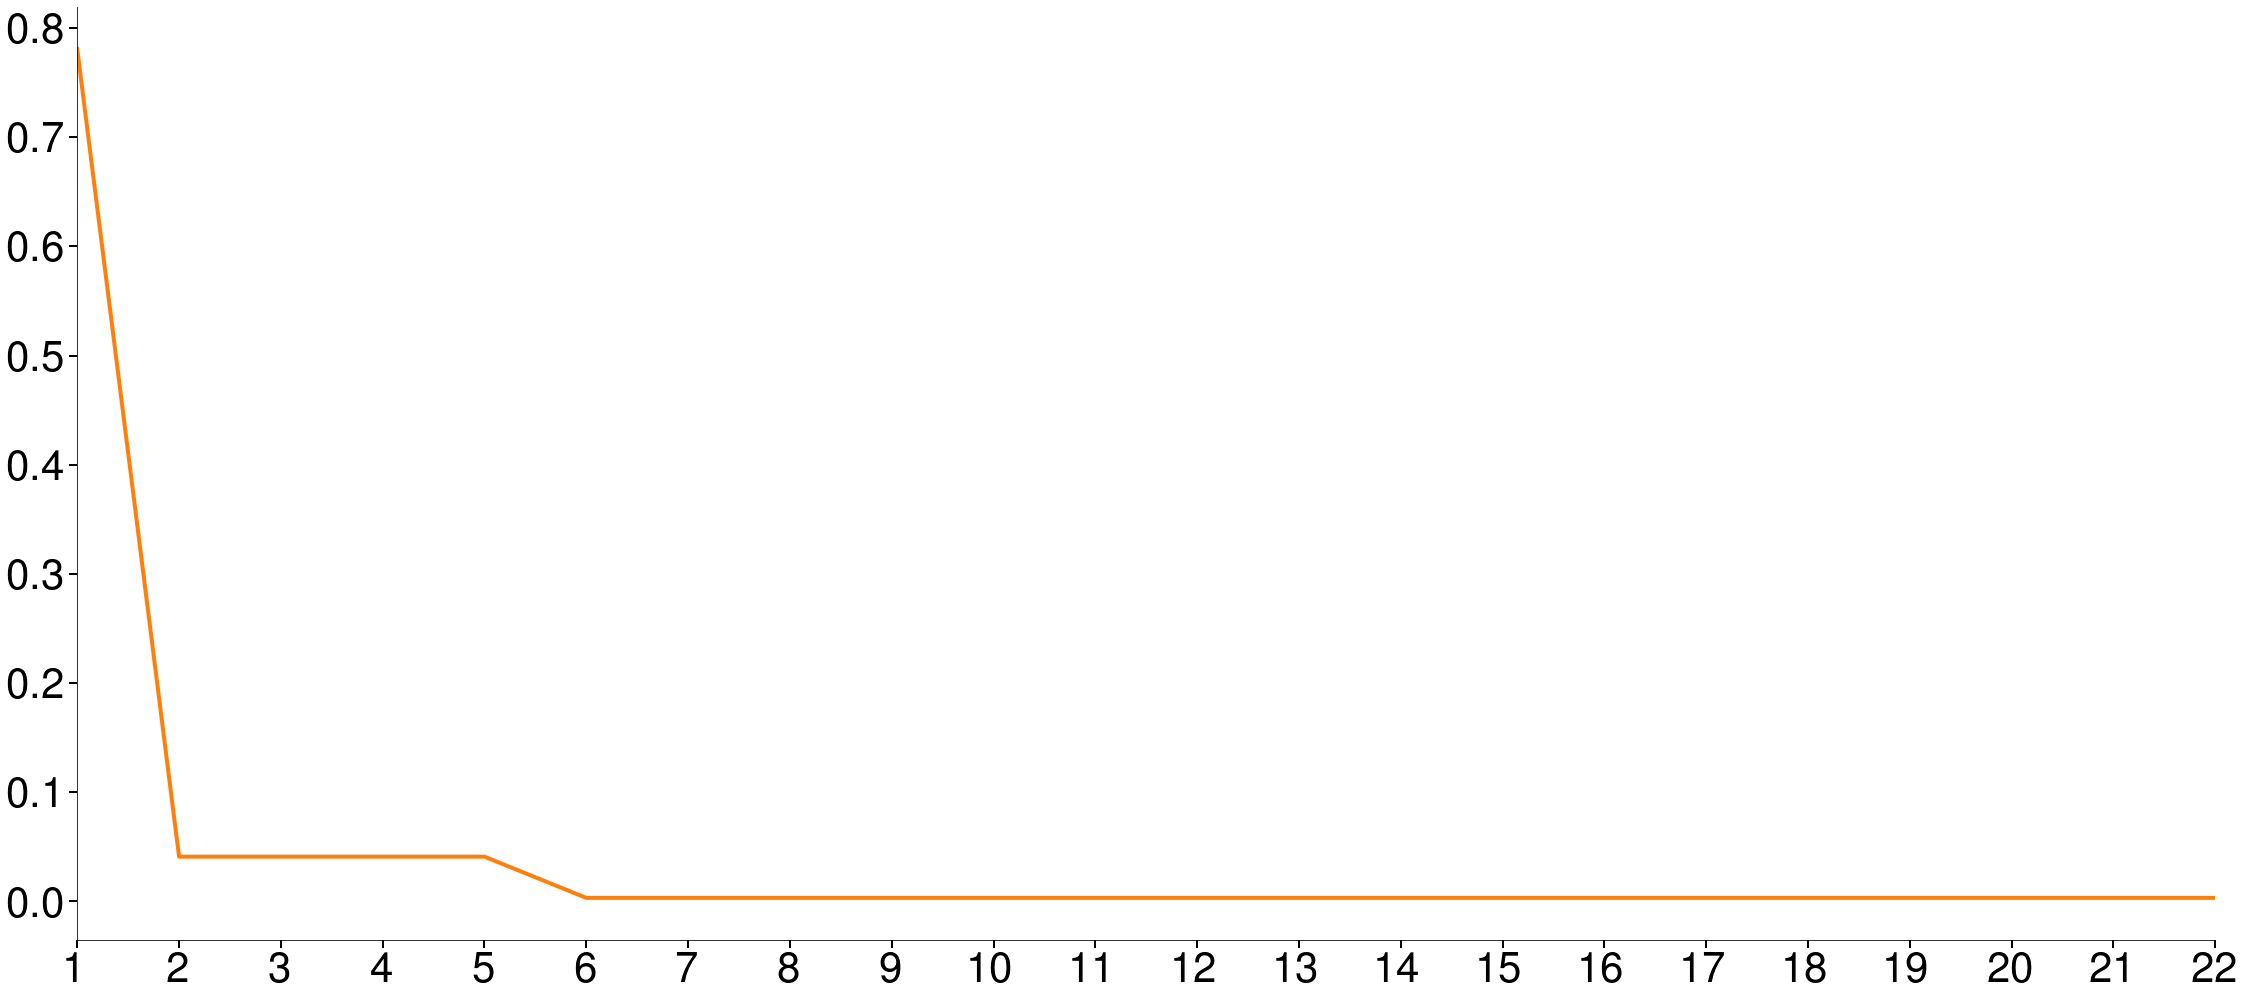

In [43]:
harch_weights()

# Implied Variance
* Implied volatility is very different from ARCH and Realized measures 
* Market based: Level of volatility is calculated from options prices 
* Forward looking: Options depend on future price path 
* “Classic” implied relies on the Black-Scholes pricing formula 
* “Model free” implied volatility exploits a relationship between the second derivative of the call price with respect to the strike and the risk neutral measure 
* VIX is a Chicago Board Options Exchange (CBOE) index based on a model free measure 
* Allows volatility to be directly traded 

# Black-Scholes Implied Volatility

* Prices follow a geometric Brownian Motion 

$$\text{d}{S}_{t}=\mu S_{t}\text{d}t+\sigma S_{t}\text{d}W_{t} $$

* Constant drift and volatility 
* Price of a call is 

$$C(T,K)=S\Phi(d_{1})+Ke^{-rT}\Phi(d_{2})$$

$$d_{1}=\frac{\ln\left(S/K\right)+\left(r+\sigma^{2}/2\right)T}{\sigma\sqrt{T}},\,\,d_{2}=\frac{\ln\left(S/K\right)+\left(r-\sigma^{2}/2\right)T}{\sigma\sqrt{T}}	$$

* Invert to produce a formula for the volatility given the call price $C(T,K)$

$$\sigma_{t}^{Implied}=g\left(C_{t}(T,K),S_{t},K,T,r\right)$$

In [44]:
import pandas as pd
import seaborn as sns

import mfe

def bsiv():
    data = pd.read_excel("code/spy-implied-volatility-exp-feb-2-2018-curr-price-277.92.xlsx")

    mfe.full_setup()

    data = data.set_index("moniness")
    data.index.name = "Moneyness"
    fig, ax = plt.subplots(1,1,figsize=mfe.DEFAULT_FIGSIZE)
    temp = data.loc[data.option_type == "Put", ["implied_vol"]].copy()
    temp.columns = ["Put IV"]
    temp.plot(ax=ax, legend=False)
    temp = data.loc[data.option_type == "Call", ["implied_vol"]]
    temp.columns = ["Call IV"]
    temp.plot(ax=ax, legend=False)
    ax.legend(frameon=False)
    fig.tight_layout(pad=1.0)
    sns.despine()


# Black-Scholes Smile

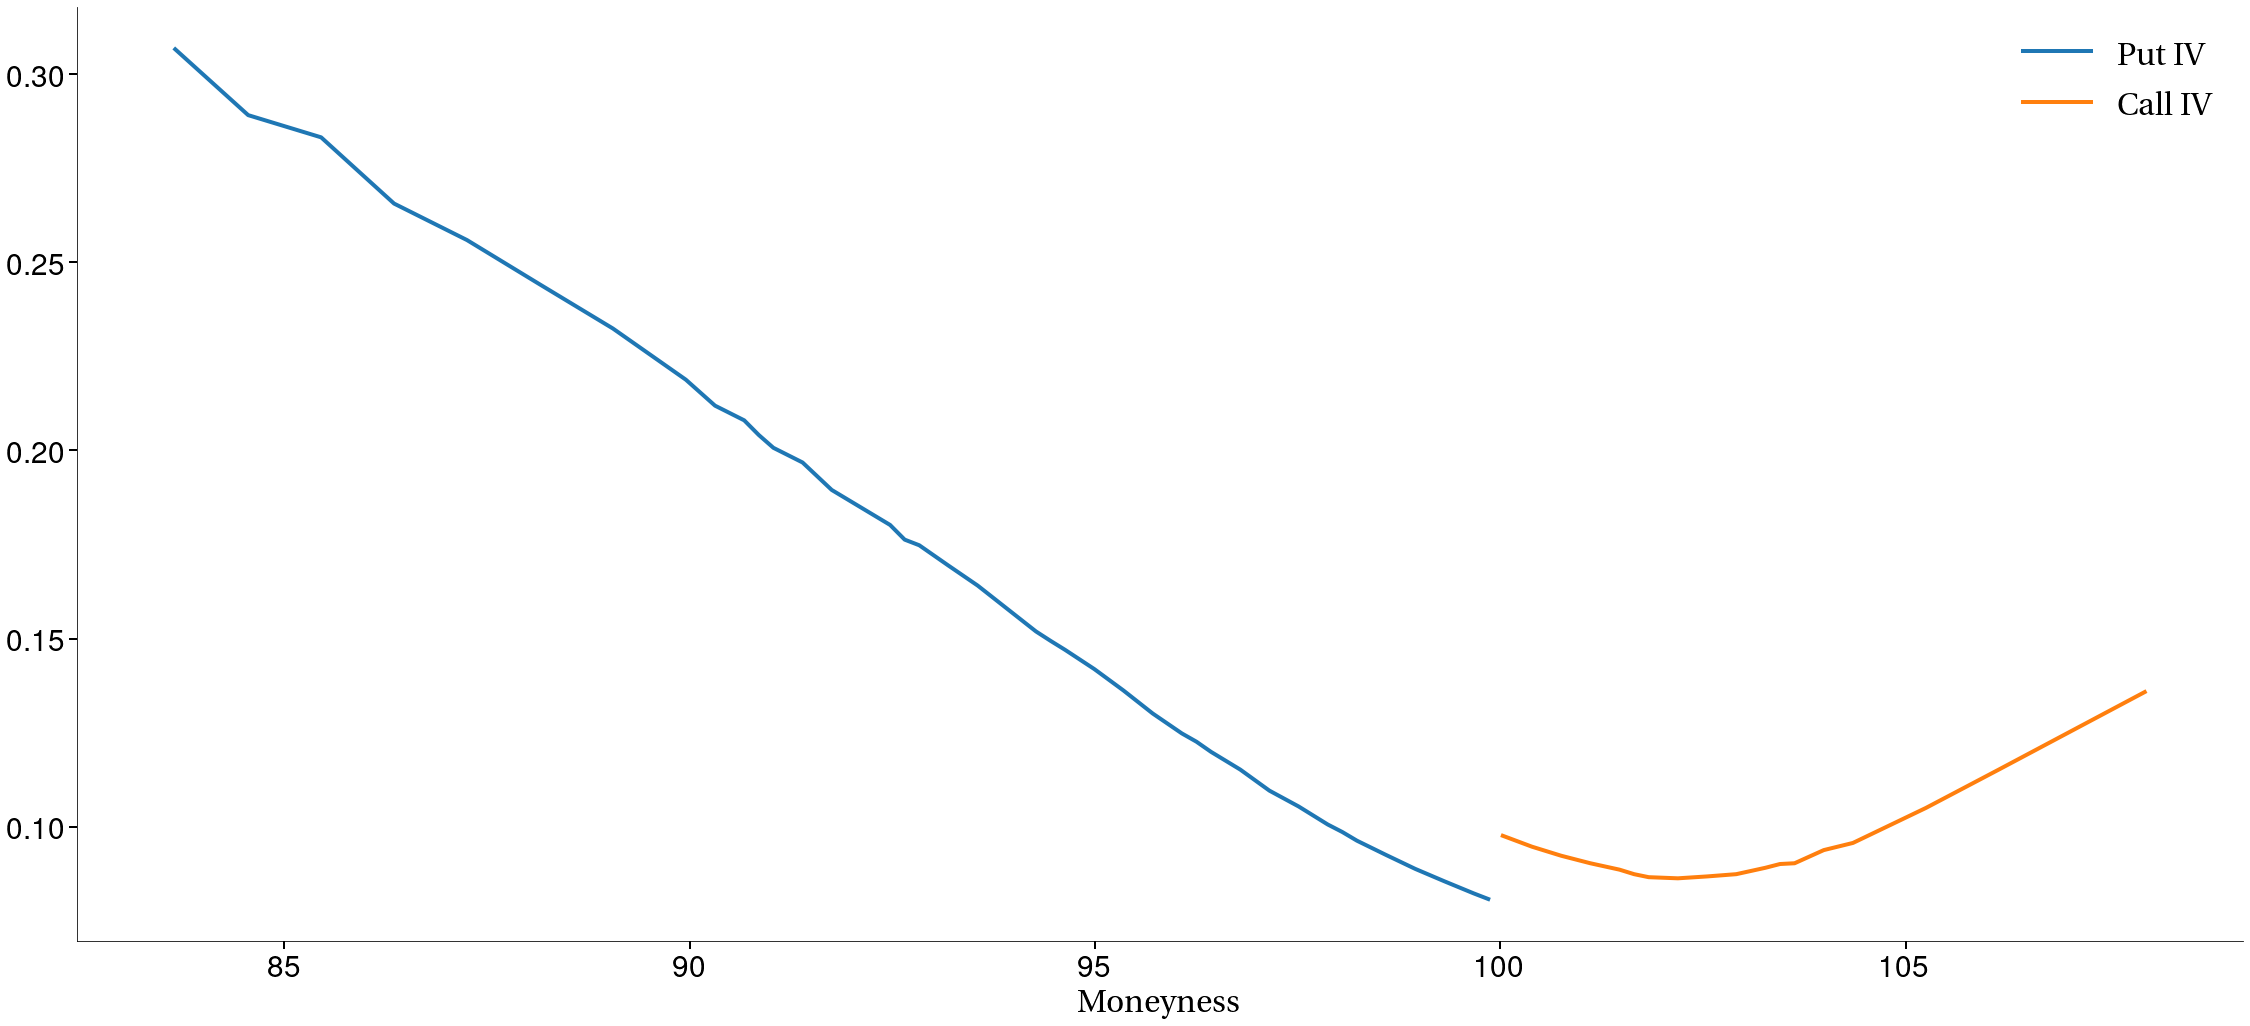

In [45]:
bsiv()

# Model-free Implied Variance

* VIX is continuously computed by the CBOE 
* Uses both out-of-the-monry calls and puts 

$$\sigma^{2}=\frac{2}{T}e^{rT}\sum_{i=1}^{N}\frac{\Delta K_{i}}{K_{i}}\frac{Q(K_{i})}{K_i}-\frac{1}{T}\left(\frac{F_{0}}{K_{0}}-1\right)^{2} $$

* $Q(K_{i})$ is the mid-quote for a strike of $K_{i}$, $K_{0}$ is the first strike below the forward index level 
* VIX appears to have information about future realized volatility that is not in other backward looking measures (GARCH/RV) 
* Computes area under curves defined by OOM options

# 20% Annualized Volatility

In [46]:
"""
blackscholes.py
"""
import seaborn as sns
import math
import scipy.stats as stats
import mfe

# Return the value of the Gaussian probability function with mean 0.0
# and standard deviation 1.0 at the given x value.


def phi(x):
    return math.exp(-x * x / 2.0) / math.sqrt(2.0 * math.pi)


# Return the value of the Gaussian probability function with mean mu
# and standard deviation sigma at the given x value.


def pdf(x, mu=0.0, sigma=1.0):
    return phi((x - mu) / sigma) / sigma


# Return the value of the cumulative Gaussian distribution function
# with mean 0.0 and standard deviation 1.0 at the given z value.


def Phi(z):
    return stats.norm().cdf(z)


# Return standard Gaussian cdf with mean mu and stddev sigma.
# Use Taylor approximation.


def cdf(z, mu=0.0, sigma=1.0):
    return Phi((z - mu) / sigma)


# Black-Scholes formula.


def callPrice(s, x, r, sigma, t):
    a = (math.log(s / x) + (r + sigma * sigma / 2.0) * t) / (sigma * math.sqrt(t))
    b = a - sigma * math.sqrt(t)
    return s * cdf(a) - x * math.exp(-r * t) * cdf(b)



r = 0.02
vol = 0.20
points = np.linspace(60, 140, 401)
points = np.array(points)
points.sort()
cp = np.empty_like(points)
pp = np.empty_like(points)
for i, k in enumerate(points):
    cp[i] = callPrice(100, k, r, vol, 1 / 12)
    d = np.exp(-r * (1 / 12))
    pp[i] = cp[i] - (100 - d * k)

def plot_20():
    fig, ax = plt.subplots(1,1,figsize=mfe.DEFAULT_FIGSIZE)
    combined_x = []
    combined_y = []

    ind = points > 100
    ax.plot(points[~ind], pp[~ind], color=mfe.colors[1])
    combined_x += points[~ind].tolist()
    combined_y += pp[~ind].tolist()
    ax.plot(points[ind], pp[ind], alpha=0.5, linestyle=":", color=mfe.colors[1])

    ind = points >= 100
    ax.plot(points[ind], cp[ind], color=mfe.colors[0])
    combined_x += points[ind].tolist()
    combined_y += cp[ind].tolist()
    ax.plot(points[~ind], cp[~ind], alpha=0.5, linestyle=":", color=mfe.colors[0])

    cand = (points - points.astype("int")) == 0
    cand &= (points >= 88) & (points <= 116) & (points.astype(int) % 4 == 0)
    cand_points = points[cand]
    cand_put = pp[cand]
    cand_call = cp[cand]
    ind = cand_points <= 100
    ax.plot(
        cand_points[ind],
        cand_put[ind],
        linestyle="none",
        marker="s",
        color=mfe.colors[1],
        markersize=12,
    )
    ax.plot(
        cand_points[ind] - 1000,
        cand_put[ind],
        marker="s",
        color=mfe.colors[1],
        markersize=12,
        label="Put Option Price",
    )
    ind = cand_points >= 100
    ax.plot(
        cand_points[ind],
        cand_call[ind],
        linestyle="none",
        marker="o",
        color=mfe.colors[0],
        markersize=12,
    )
    ax.plot(
        cand_points[ind] - 1000,
        cand_call[ind],
        marker="o",
        color=mfe.colors[0],
        markersize=12,
        label="Call Option Price",
    )
    ax.set_xlim(points[0], points[-1])
    ax.set_ylim(-0.02, 4)
    ax.set_xticks(np.arange(60, 141, 4))
    ax.set_yticks(np.arange(0, 5))
    combined_x = np.array(combined_x)
    combined_y = np.array(combined_y)
    ax.fill_between(
        combined_x, combined_y, alpha=0.33, label="VIX Area", color=mfe.colors[7]
    )
    ax.legend(frameon=False)
    ax.set_ylabel("Option Price")
    ax.set_xlabel("Strike Price")
    sns.despine()
    fig.tight_layout(pad=1.0)

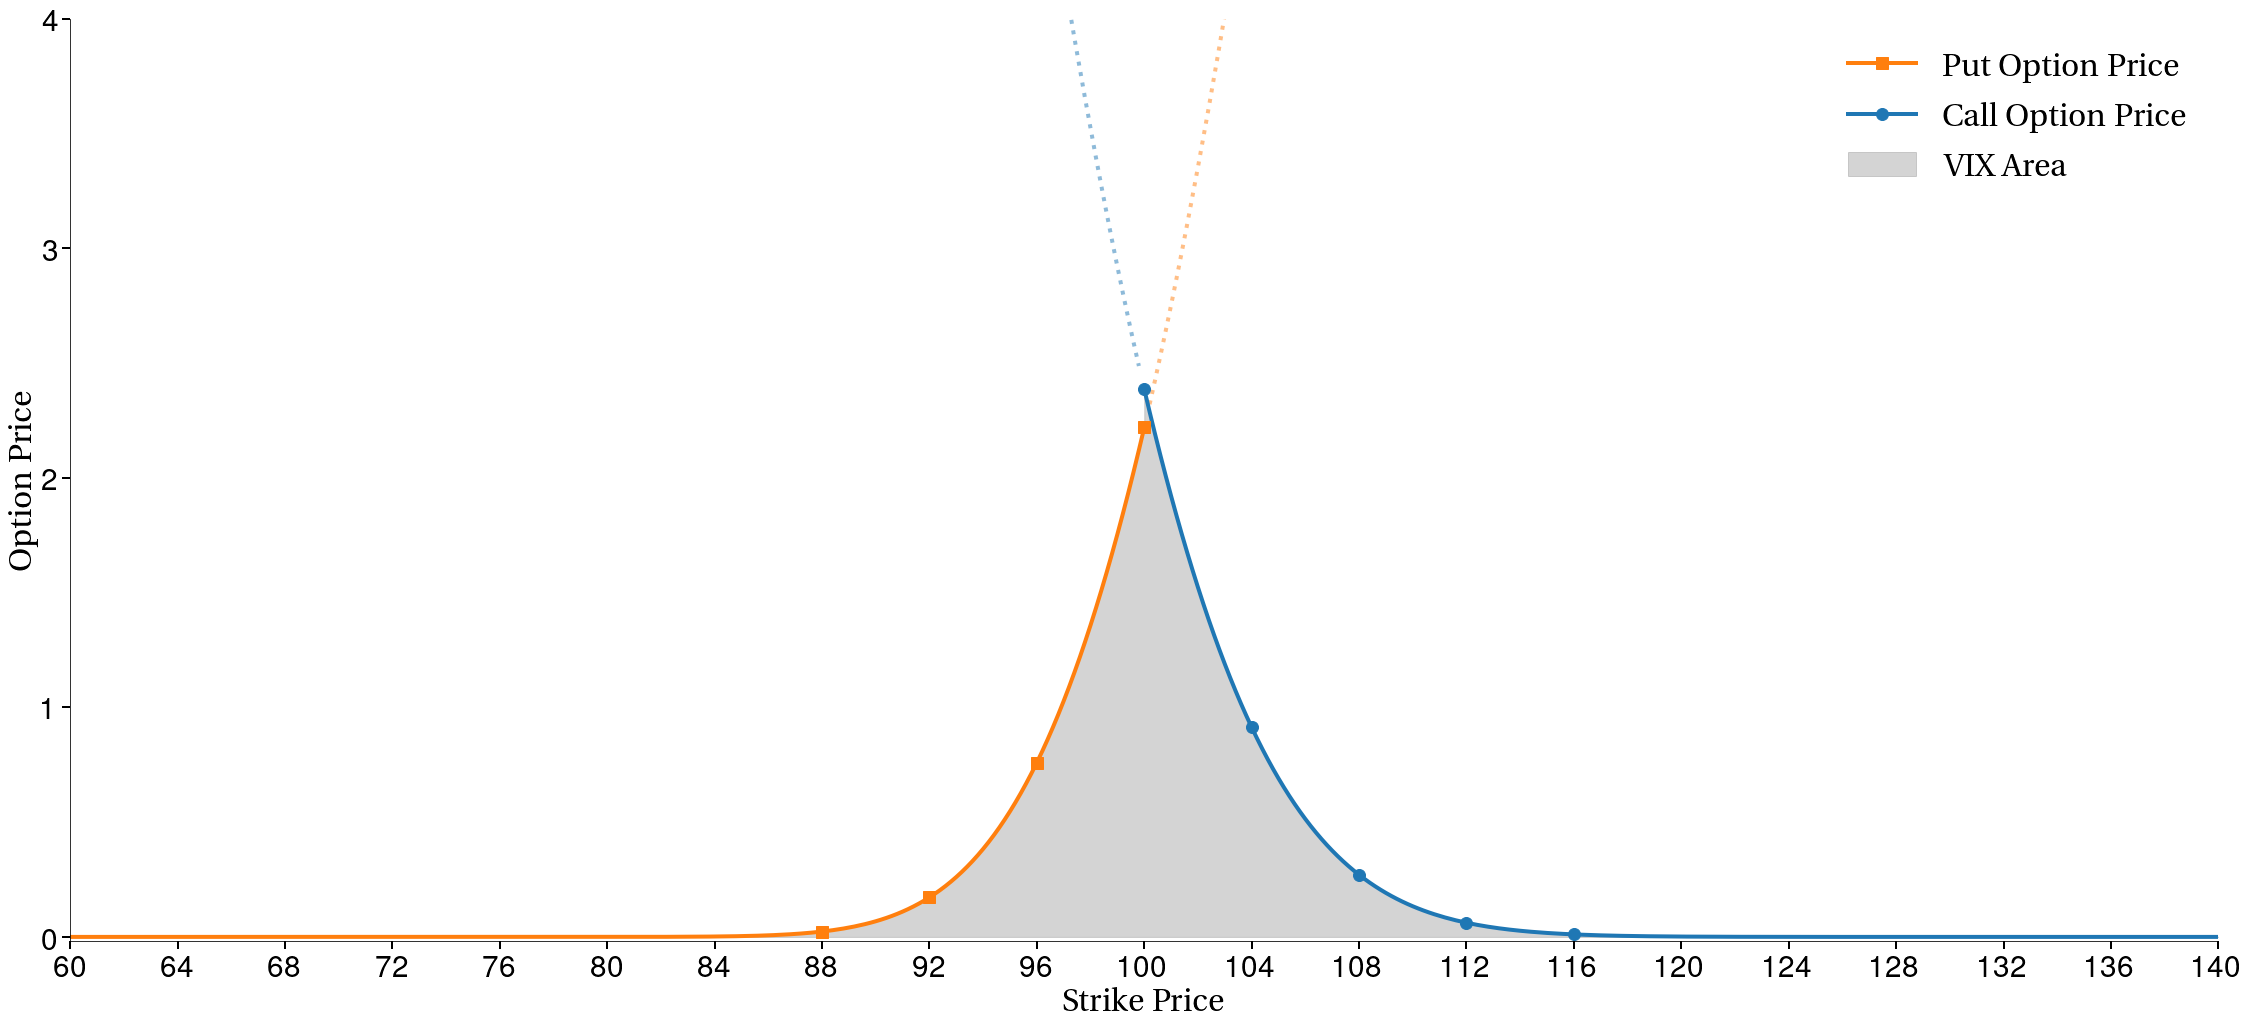

In [47]:
plot_20()

In [48]:

#%%

r = 0.02
vol = 0.60
points = np.linspace(60, 140, 401)
points = np.array(points)
points.sort()
cp = np.empty_like(points)
pp = np.empty_like(points)
for i, k in enumerate(points):
    cp[i] = callPrice(100, k, r, vol, 1 / 12)
    d = np.exp(-r * (1 / 12))
    pp[i] = cp[i] - (100 - d * k)
def plot_60():
    fig, ax = plt.subplots(1,1,figsize=mfe.DEFAULT_FIGSIZE)
    combined_x = []
    combined_y = []

    ind = points > 100
    ax.plot(points[~ind], pp[~ind], color=mfe.colors[1])
    combined_x += points[~ind].tolist()
    combined_y += pp[~ind].tolist()
    ax.plot(points[ind], pp[ind], alpha=0.5, linestyle=":", color=mfe.colors[1])

    ind = points >= 100
    ax.plot(points[ind], cp[ind], color=mfe.colors[0])
    combined_x += points[ind].tolist()
    combined_y += cp[ind].tolist()
    ax.plot(points[~ind], cp[~ind], alpha=0.5, linestyle=":", color=mfe.colors[0])

    cand = (points - points.astype("int")) == 0
    cand &= (points >= 40) & (points <= 160) & (points.astype(int) % 4 == 0)
    cand_points = points[cand]
    cand_put = pp[cand]
    cand_call = cp[cand]
    ind = cand_points <= 100
    ind &= (cand_put > 0.01) & (cand_call > 0.01)
    ax.plot(
        cand_points[ind],
        cand_put[ind],
        linestyle="none",
        marker="s",
        color=mfe.colors[1],
        markersize=12,
    )
    ax.plot(
        cand_points[ind] - 1000,
        cand_put[ind],
        marker="s",
        color=mfe.colors[1],
        markersize=12,
        label="Put Option Price",
    )
    ind = cand_points >= 100
    ax.plot(
        cand_points[ind],
        cand_call[ind],
        linestyle="none",
        marker="o",
        color=mfe.colors[0],
        markersize=12,
    )
    ax.plot(
        cand_points[ind] - 1000,
        cand_call[ind],
        marker="o",
        color=mfe.colors[0],
        markersize=12,
        label="Call Option Price",
    )
    ax.set_xlim(points[0], points[-1])
    ax.set_ylim(-0.02, 10)
    ax.set_xticks(np.arange(60, 141, 4))
    ax.set_yticks(np.arange(0, 11, 2))
    combined_x = np.array(combined_x)
    combined_y = np.array(combined_y)
    ax.fill_between(
        combined_x, combined_y, alpha=0.33, label="VIX Area", color=mfe.colors[7]
    )
    ax.legend(frameon=False)
    ax.set_ylabel("Option Price")
    ax.set_xlabel("Strike Price")
    sns.despine()
    fig.tight_layout(pad=1.0)



# 60% Annualized Volatility

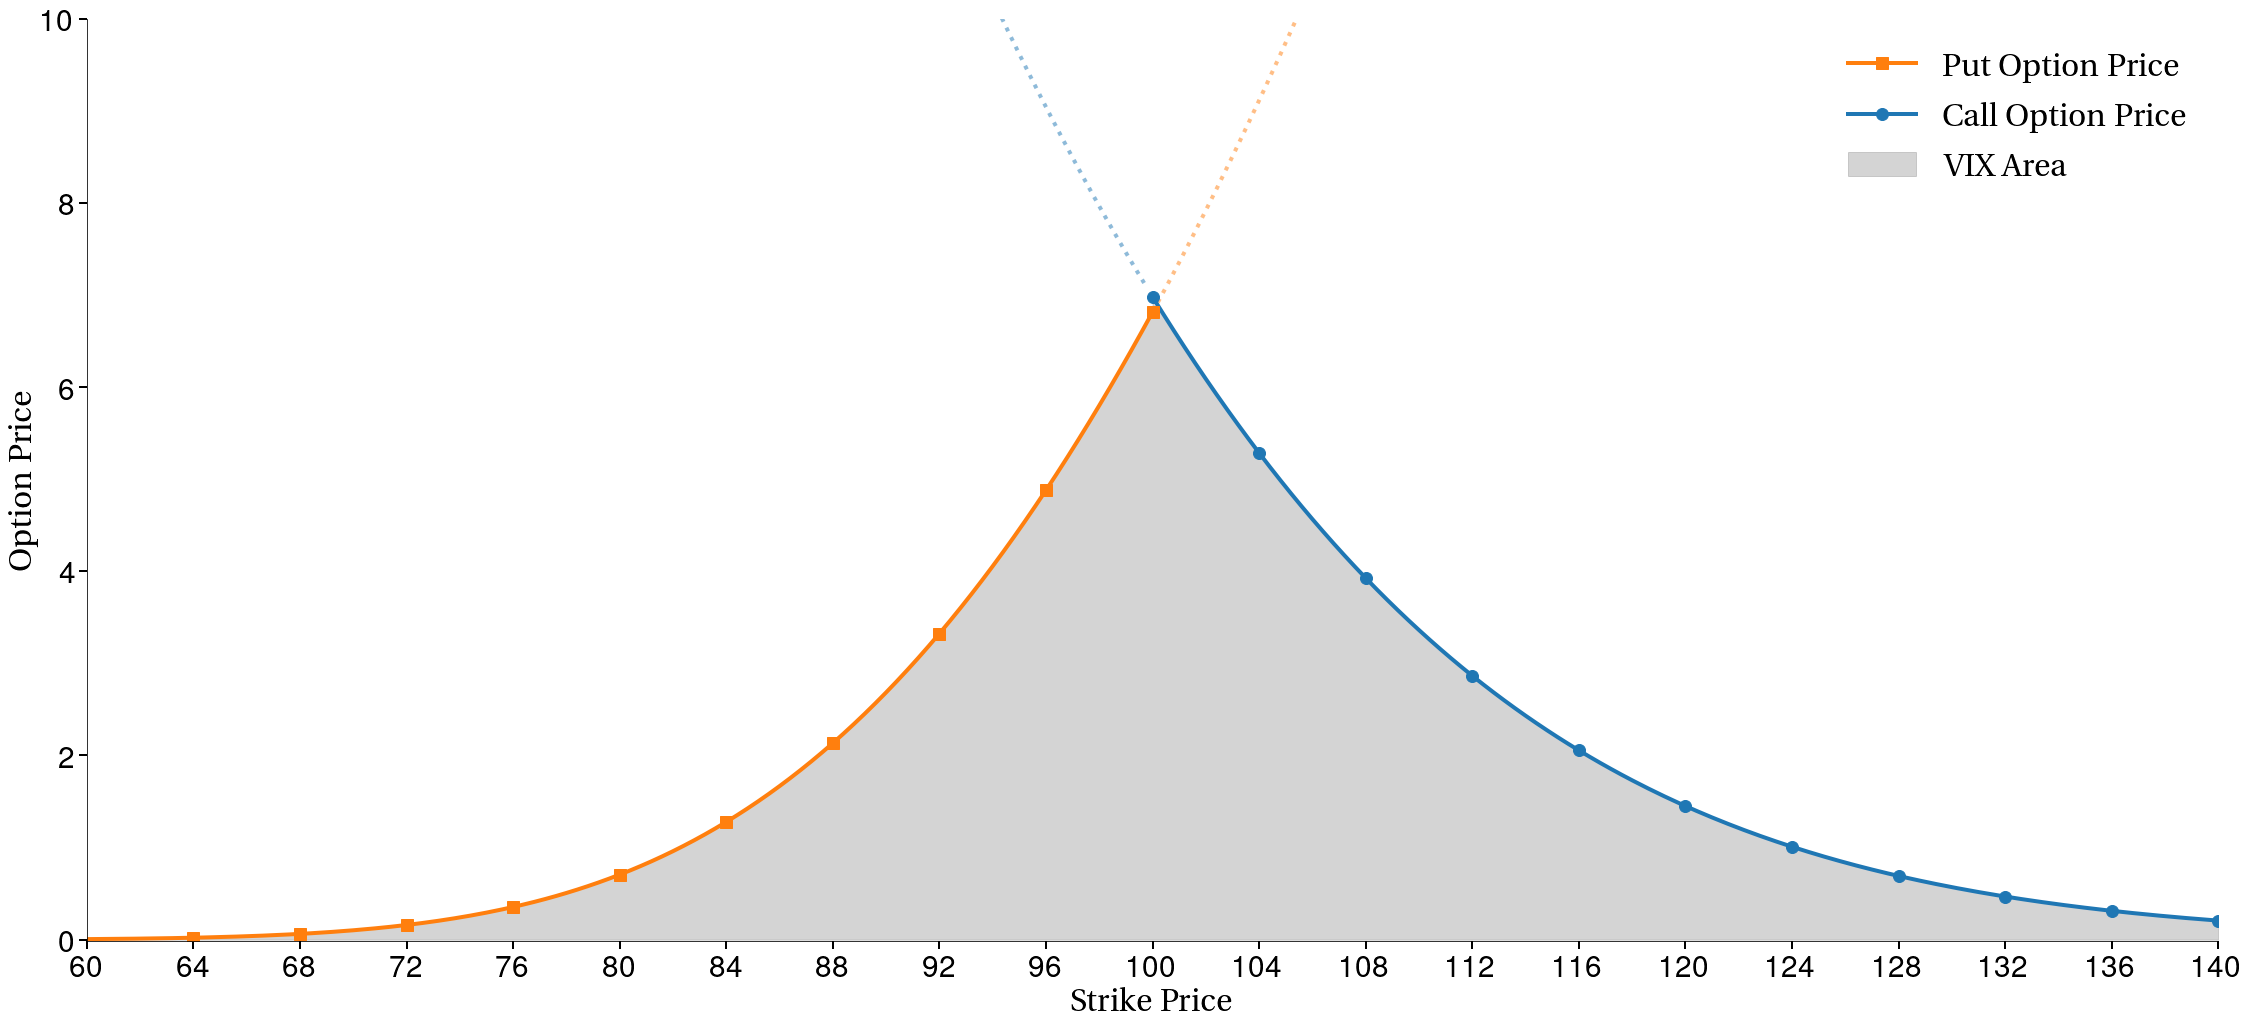

In [49]:
plot_60()

# Next Week

* Risk Management
  * Value-at-Risk
  * Expected Shortfall
  